# Capstone 3: Modeling
<b>PROJECT GOAL</b><br>
The goal of this project is to understand and predict the valuation of publicly-traded companies as measured by market capitalization (the target or response variable).  Financial statement data will be used as predictor variables (features) to assess whether regression models of these fundamental variables can predict future market capitalization.<br>

<b>DATA</b><br>
All data are sourced from Alpha Vantage via their API (https://www.alphavantage.co/documentation/).

<i>response variable (target)</i><br>
market capitalization = [number of shares outstanding] x [share price]<br><br>
<i>predictor variables (features)</i><br>
The features are metrics from financial statements such as revenue, revenue growth year-over-year, etc.  A core set of metrics to be used as features was defined in the exploratory data analysis notebook.

Features are measured with respect to a quarterly fiscal reporting date, 'fisc_date_t', and with respect to dates relative to that date.  Financial statement metrics are measured on dates such as current quarter ('fisc_date_t'), next quarter ('fisc_date_tp1'), prior quarter ('fisc_date_tm1'), prior year ('fisc_date_tm4'), and prior quarter in the prior year ('fisc_date_tm5').  Stock prices are measured on measurement dates with respect to fiscal reporting dates, where the current measurement date ('meas_date_t') is the most recent trading date prior to the current fiscal reporting date ('fisc_date_t') and the next period measurement date ('meas_date_tp1') is similarly measured with respect to the next fiscal reporting date ('fisc_date_tp1') 

The target, market capitalization, 'mktcap_sec_tp1', is measured on date 'meas_date_tp1', the most recent trading date just prior to the next fiscal reporting date, 'fisc_date_tp1'.  The machine learning problem is to predict market capitalization ('mktcap_sec_tp1') just prior to the next fiscal reporting date ('fisc_date_tp1') using feature measurements from the current fiscal reporting date ('fisc_date_t').

The features are identical to those used in preprocessing and training except here I add 4 indicator/flag predictor variables ('gp_mgn_flg', 'sh_iss_flg', 'sh_rprch_flg', 'div_flg'; values are 0 or 1 for each). Base on prior analyses, I posited that these indicator vaiables may help define the feature space and help scale the data.  Hence, the core features used in the analysis are:

clsadj_etf_t = adjusted close price of ETF ticker VTI on the most recent trading date prior to the current fiscal reporting date

rev = revenue for the fiscal quarter ending on the current fiscal reporting date<br> 
rev_yoy = year-over-year percent change in quarterly revenue for the current fiscal reporting date versus prior year<br>
rev_yoy_qdq = current quarter rev_yoy minus prior quarter rev_yoy

gp_mgn_flg = 1 if gp_mgn = 1, 0 otherwise
gp = gross profit for the fiscal quarter ending on the current fiscal reporting date<br> 
gp_mgn = gross profit margin, gross profit divided by revenue, for the fiscal quarter ending on the current fiscal reporting date<br>
gp_mgn_ydy = current quarter gross profit margin minus prior year gross profit margin

ni = net income for the fiscal quarter ending on the current fiscal reporting date <br>
ni_ydy = current quarter net income minus prior year net income<br>
ni_mgn = net income margin, net income divided by revenue, for the fiscal quarter ending on the current fiscal reporting date<br>
ni_mgn_ydy = current quarter net income margin minus prior year net income margin

sh_iss_flg = 1 if total share issue amount > 0, 0 otherwise
sh_iss = total share issue amount in USD for the fiscal quarter ending on the current fiscal reporting date<br> 
sh_rprch_flg = 1 if total share repurchase amount > 0, 0 otherwise
sh_rprch = total share repurchase amount in USD for the fiscal quarter ending on the current fiscal reporting date<br> 
div_flg = 1 if total dividend amount > 0, 0 otherwise
div = total dividend amount in USD paid for the fiscal quarter ending on the current fiscal reporting date<br> 
div_ydy = current quarter total dividend amount minus prior year total dividend amount

cf_op = operating cash flow for the fiscal quarter ending on the current fiscal reporting date<br>
cf_op_ydy = current quarter operating cash flow minus prior year operating cash flow<br>
cf_op_mgn = operating cash flow margin, operating cash flow divided by revenue, for the fiscal quarter ending on the current fiscal reporting date<br>
cf_op_mgn_ydy = current quarter operating cash flow margin minus prior year operating cash flow margin

The data set has
* 2,122 distinct stock tickers
* 9,723 observations
* 1,692 (80%) stocks tickers with 5 observations 
* stock tickers with market cap in Sep 2021 ranging from \\$1.006 billion to \\$2.358 trillion 
* fiscal reporting dates ranging from 2020-01-31 to 2021-06-04

<b>MODELING NOTEBOOK</b><br>
The purpose of this notebook is to:
<ol type="1">
  <li>implement additional and enhanced feature engineering to transform and scale the data with the goal of improving model performance,</li>
  <li>re-fit a set of machine learning models from the preprocesing and training notebook ('baseline') on the enhanced features,</li>
  <li>define, build and fit (train) some basic neural network models,</li>
  <li>evaluate and compare all models in terms of predictive accuracy and feature importance,</li>
  <li>identify paths for further exploration and analysis to improve the data and modeling for the core business use case: predicting market capitalization in the next fiscal period given information known as of the current fiscal period.</li>
</ol> 

## 1 Import Python Modules, Load Data

Import Python modules and load target and feature data from the output of the exploratory data analysis notebook.

In [1]:
import pandas as pd
import numpy as np
import datetime as dttm
import itertools as itool

from sklearn.preprocessing import StandardScaler, PowerTransformer   #QuantileTransformer, RobustScaler
from sklearn.metrics import SCORERS, r2_score
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

import xgboost as xgb

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import initializers, layers
from keras.layers import Input, Lambda

import matplotlib.pyplot as plt
import seaborn as sns
#import graphviz

import json

Save a copy of the virtual environment to a text file.

In [2]:
#virtual environment
!pip freeze > env_spbdcp031.txt

In [3]:
#as of date
statusdate01 = dttm.date(2021,9,30)

In [4]:
#load target, feature data
data_elmt011 = 'yxdata_eda_'

#json
filnm011 = '../data/sec_' + data_elmt011 + statusdate01.strftime('%Y%m%d') + '.json'

with open(filnm011) as f011:
    sec_res_dict011 = json.load(f011)
        
df_sec_yxdata011 = pd.DataFrame.from_dict(sec_res_dict011)

lst_yxdata_dates011 = ['fisc_date_t', 'fisc_date_tp1', 'meas_date_t', 'meas_date_tp1', 
    'rpt_date_t', 'rpt_date_tp1', 'fisc_date_tm1', 'fisc_date_tm4', 'fisc_date_tm5']

for lst_date_itm011 in lst_yxdata_dates011:
    df_sec_yxdata011.loc[:,lst_date_itm011] = pd.to_datetime(df_sec_yxdata011.loc[:,lst_date_itm011])
    
del f011, sec_res_dict011

In [5]:
#define core metrics, data
lst_yx_coreattmet011 = ['ticker','mkt_cap_202109','fisc_seq','fisc_intvl','rpt_ccy','inscope_flg',
    'fisc_date_t', 'fisc_date_tm1', 'fisc_date_tm4', 'fisc_date_tm5', 'meas_date_tp1',
    'mktcap_sec_tp1',
    'clsadj_etf_t',
    'rev', 'rev_yoy', 'rev_yoy_qdq', 
    'gp', 'gp_mgn', 'gp_mgn_ydy', 
    'ni', 'ni_ydy', 'ni_mgn', 'ni_mgn_ydy', 
    'sh_iss', 'sh_rprch', 'div', 'div_ydy',
    'cf_op', 'cf_op_ydy', 'cf_op_mgn', 'cf_op_mgn_ydy']

#in scope, core attributes & metrics
is_yx_inscope011 = df_sec_yxdata011.loc[:,'inscope_flg'] == True
df_sec_yxdata_core011 = df_sec_yxdata011.loc[is_yx_inscope011,lst_yx_coreattmet011].copy()
df_sec_yxdata_core011.reset_index(drop=True,inplace=True)
df_sec_yxdata_core011.info()
df_sec_yxdata_core011.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9723 entries, 0 to 9722
Data columns (total 31 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   ticker          9723 non-null   object        
 1   mkt_cap_202109  9723 non-null   float64       
 2   fisc_seq        9723 non-null   float64       
 3   fisc_intvl      9723 non-null   float64       
 4   rpt_ccy         9723 non-null   object        
 5   inscope_flg     9723 non-null   bool          
 6   fisc_date_t     9723 non-null   datetime64[ns]
 7   fisc_date_tm1   9723 non-null   datetime64[ns]
 8   fisc_date_tm4   9723 non-null   datetime64[ns]
 9   fisc_date_tm5   9723 non-null   datetime64[ns]
 10  meas_date_tp1   9723 non-null   datetime64[ns]
 11  mktcap_sec_tp1  9723 non-null   float64       
 12  clsadj_etf_t    9723 non-null   float64       
 13  rev             9723 non-null   float64       
 14  rev_yoy         9723 non-null   float64       
 15  rev_

,ticker,mkt_cap_202109,fisc_seq,fisc_intvl,rpt_ccy,inscope_flg,fisc_date_t,fisc_date_tm1,fisc_date_tm4,fisc_date_tm5,...,ni_mgn,ni_mgn_ydy,sh_iss,sh_rprch,div,div_ydy,cf_op,cf_op_ydy,cf_op_mgn,cf_op_mgn_ydy
0,AAPL,2.358033e+12,5.0,91.0,USD,True,2021-03-31,2020-12-31,2020-03-31,2019-12-31,...,0.265762,0.070318,561000000.0,1.854800e+10,3.447000e+09,72000000.0,2.398100e+10,1.067000e+10,0.269710,0.038440
1,AAPL,2.358033e+12,4.0,90.0,USD,True,2020-12-31,2020-09-30,2019-12-31,2019-09-30,...,0.259519,0.015259,0.0,2.477500e+10,3.613000e+09,74000000.0,3.876300e+10,8.247000e+09,0.349843,0.014628
2,AAPL,2.358033e+12,3.0,92.0,USD,True,2020-09-30,2020-06-30,2019-09-30,2019-06-30,...,0.195879,-0.017831,450000000.0,1.718700e+10,3.511000e+09,32000000.0,2.057600e+10,6.660000e+08,0.318031,0.007132
3,AAPL,2.358033e+12,2.0,92.0,USD,True,2020-06-30,2020-03-31,2019-06-30,2019-03-31,...,0.190768,0.001054,0.0,1.589100e+10,3.656000e+09,27000000.0,1.627100e+10,4.635000e+09,0.275836,0.056052
4,AAPL,2.358033e+12,1.0,91.0,USD,True,2020-03-31,2019-12-31,2019-03-31,2018-12-31,...,0.195444,-0.007362,428000000.0,1.857400e+10,3.375000e+09,-68000000.0,1.331100e+10,2.156000e+09,0.231270,0.035586


## 2 Feature Engineering: Transform and Scale Data

In this section, I perform some additional feature engineering that is informed by the prior analyses.  The aim is to further define the feature space and better scale the data to improvde model performance.

I perform the following,
<ol type="1">
  <li>add 4 indicator variables as features, as define above in the introduction,</li>
  <li>tranform features with large values (USD amounts) using a square root tranform with the aim of reducing the long tails in these distributions and making the data more normally-distributed (variables that are percentages or indicator flags are not sqaure-root transformed, also the variable 'clsadj_etf_t' is not transformed),</li>
  <li>regress all USD amount variables (except revenue, 'rev'), including the target variable, on revenue, calculate the residuals for each regression and use these residuals (after scaling in next step, below) as new target and feature variables to further scale the data,</li>
  <li>standardized all non-indicator variables by centering on the mean and dividing by the standard deviation.
</ol> 

The idea of the above transformations is to reduce the long tails in some of the distributions, to more normalize the data, and to scale the data to 0 mean and unit standard deviation.

<b>2.1 INDICATOR VARIABLES DEFINED</b>

Here, I define the four new indicator variables.

In [6]:
#add indicator features
df_sec_yxdata_core011['gp_mgn_flg'] = df_sec_yxdata_core011.loc[:,'gp_mgn'].apply(lambda x: 1 if x != 1 else 0)
df_sec_yxdata_core011['sh_iss_flg'] = df_sec_yxdata_core011.loc[:,'sh_iss'].apply(lambda x: 1 if x != 0 else 0)
df_sec_yxdata_core011['sh_rprch_flg'] = df_sec_yxdata_core011.loc[:,'sh_rprch'].apply(lambda x: 1 if x != 0 else 0)
df_sec_yxdata_core011['div_flg'] = df_sec_yxdata_core011.loc[:,'div'].apply(lambda x: 1 if x != 0 else 0)

In [7]:
df_sec_yxdata_core011.head()

,ticker,mkt_cap_202109,fisc_seq,fisc_intvl,rpt_ccy,inscope_flg,fisc_date_t,fisc_date_tm1,fisc_date_tm4,fisc_date_tm5,...,div,div_ydy,cf_op,cf_op_ydy,cf_op_mgn,cf_op_mgn_ydy,gp_mgn_flg,sh_iss_flg,sh_rprch_flg,div_flg
0,AAPL,2.358033e+12,5.0,91.0,USD,True,2021-03-31,2020-12-31,2020-03-31,2019-12-31,...,3.447000e+09,72000000.0,2.398100e+10,1.067000e+10,0.269710,0.038440,1,1,1,1
1,AAPL,2.358033e+12,4.0,90.0,USD,True,2020-12-31,2020-09-30,2019-12-31,2019-09-30,...,3.613000e+09,74000000.0,3.876300e+10,8.247000e+09,0.349843,0.014628,1,0,1,1
2,AAPL,2.358033e+12,3.0,92.0,USD,True,2020-09-30,2020-06-30,2019-09-30,2019-06-30,...,3.511000e+09,32000000.0,2.057600e+10,6.660000e+08,0.318031,0.007132,1,1,1,1
3,AAPL,2.358033e+12,2.0,92.0,USD,True,2020-06-30,2020-03-31,2019-06-30,2019-03-31,...,3.656000e+09,27000000.0,1.627100e+10,4.635000e+09,0.275836,0.056052,1,0,1,1
4,AAPL,2.358033e+12,1.0,91.0,USD,True,2020-03-31,2019-12-31,2019-03-31,2018-12-31,...,3.375000e+09,-68000000.0,1.331100e+10,2.156000e+09,0.231270,0.035586,1,1,1,1


In [8]:
#core attributes, target & features, features
lst_yx_coreatt011 = ['ticker','mkt_cap_202109','fisc_seq','fisc_intvl','rpt_ccy','inscope_flg',
    'fisc_date_t', 'fisc_date_tm1', 'fisc_date_tm4', 'fisc_date_tm5', 'meas_date_tp1' ]
lst_yx_coretrgtfeat011 = [
    'mktcap_sec_tp1',
    'clsadj_etf_t',
    'rev', 'rev_yoy', 'rev_yoy_qdq', 
    'gp_mgn_flg', 'gp', 'gp_mgn', 'gp_mgn_ydy', 
    'ni', 'ni_ydy', 'ni_mgn', 'ni_mgn_ydy', 
    'sh_iss_flg', 'sh_iss', 'sh_rprch_flg', 'sh_rprch', 'div_flg', 'div', 'div_ydy',
    'cf_op', 'cf_op_ydy', 'cf_op_mgn', 'cf_op_mgn_ydy']
lst_yx_corefeat011 = [
    'clsadj_etf_t',
    'rev', 'rev_yoy', 'rev_yoy_qdq', 
    'gp_mgn_flg', 'gp', 'gp_mgn', 'gp_mgn_ydy', 
    'ni', 'ni_ydy', 'ni_mgn', 'ni_mgn_ydy', 
    'sh_iss_flg', 'sh_iss', 'sh_rprch_flg', 'sh_rprch', 'div_flg', 'div', 'div_ydy',
    'cf_op', 'cf_op_ydy', 'cf_op_mgn', 'cf_op_mgn_ydy']

#train
is_train_core_seq011 = df_sec_yxdata_core011.loc[:,'fisc_seq'] <= 4.0
df_yx_train_core011 = df_sec_yxdata_core011.loc[is_train_core_seq011,lst_yx_coretrgtfeat011]
#test
df_yx_test_core011 = df_sec_yxdata_core011.loc[~is_train_core_seq011,lst_yx_coretrgtfeat011]

<b>2.2 TRANSFORMATIONS DEFINED</b>

I define a reference/mapping table that defines the tranformations for each variable and I then define 3 functions to implement the following: (a) fit the transformation, (b) transform data given a fitted transformation, and (c) inverse transform data given a fitted transformation.

In [9]:
lst_yx_transcale012 = [
    ['mktcap_sec_tp1', 't_pwr', 'flg_none', 's12_pwrxrev_resid', 's22_mnstd'], 
    
    ['clsadj_etf_t', 't_none', 'flg_none', 's11_none', 's22_mnstd'],
    ['rev', 't_pwr', 'flg_none', 's11_none', 's22_mnstd'],  
    ['rev_yoy', 't_none', 'flg_none', 's11_none', 's22_mnstd'], 
    ['rev_yoy_qdq', 't_none', 'flg_none', 's11_none', 's22_mnstd'],  
    
    ['gp', 't_pwr', 'gp_mgn_flg', 's13_pwrflgxrev_resid', 's22_mnstd'],     
    ['gp_mgn_flg', 't_none', 'flg_none', 's11_none', 's21_none'],   
    ['gp_mgn', 't_none', 'gp_mgn_flg', 's11_none', 's22_mnstd'],   
    ['gp_mgn_ydy', 't_none', 'gp_mgn_flg', 's11_none', 's22_mnstd'],   
    
    ['ni', 't_pwr', 'flg_none', 's12_pwrxrev_resid', 's22_mnstd'],    
    ['ni_ydy', 't_pwr', 'flg_none', 's12_pwrxrev_resid', 's22_mnstd'],   
    ['ni_mgn', 't_none', 'flg_none', 's11_none', 's22_mnstd'],   
    ['ni_mgn_ydy', 't_none', 'flg_none', 's11_none', 's22_mnstd'],    
    
    ['sh_iss_flg', 't_none', 'flg_none', 's11_none', 's21_none'],    
    ['sh_iss', 't_pwr', 'sh_iss_flg', 's13_pwrflgxrev_resid', 's22_mnstd'],   
    
    ['sh_rprch_flg', 't_none', 'flg_none', 's11_none', 's21_none'],  
    ['sh_rprch', 't_pwr', 'sh_rprch_flg', 's13_pwrflgxrev_resid', 's22_mnstd'],   
    
    ['div_flg', 't_none', 'flg_none', 's11_none', 's21_none'],   
    ['div', 't_pwr', 'div_flg', 's13_pwrflgxrev_resid', 's22_mnstd'],   
    ['div_ydy', 't_pwr', 'div_flg', 's13_pwrflgxrev_resid', 's22_mnstd'],   
    
    ['cf_op', 't_pwr', 'flg_none', 's12_pwrxrev_resid', 's22_mnstd'],   
    ['cf_op_ydy', 't_pwr', 'flg_none', 's12_pwrxrev_resid', 's22_mnstd'],  
    ['cf_op_mgn', 't_none', 'flg_none', 's11_none', 's22_mnstd'],    
    ['cf_op_mgn_ydy', 't_none', 'flg_none', 's11_none', 's22_mnstd'] ]   

df_yx_transcale012 = pd.DataFrame(lst_yx_transcale012, columns=['feat','transform','mix_flg','scale01','scale02'])
df_yx_transcale012

,feat,transform,mix_flg,scale01,scale02
0,mktcap_sec_tp1,t_pwr,flg_none,s12_pwrxrev_resid,s22_mnstd
1,clsadj_etf_t,t_none,flg_none,s11_none,s22_mnstd
2,rev,t_pwr,flg_none,s11_none,s22_mnstd
3,rev_yoy,t_none,flg_none,s11_none,s22_mnstd
4,rev_yoy_qdq,t_none,flg_none,s11_none,s22_mnstd
5,gp,t_pwr,gp_mgn_flg,s13_pwrflgxrev_resid,s22_mnstd
6,gp_mgn_flg,t_none,flg_none,s11_none,s21_none
7,gp_mgn,t_none,gp_mgn_flg,s11_none,s22_mnstd
8,gp_mgn_ydy,t_none,gp_mgn_flg,s11_none,s22_mnstd
9,ni,t_pwr,flg_none,s12_pwrxrev_resid,s22_mnstd


This transform fit function fits the transform operatons on the data and returns the transformed data along with some parameters and metrics that define the tranformation so that the tranform can be applied on other data sets having the same feature set (e.g., test data). Here, the parameter k = 2 yields the square root tranform.

The square root transform used here preserves the sign and ordering by calculating the tranform of x, u=u(x), as u(x) = sign(x)(sign(x)x)<sup>2</sup>.  For the regressions of u = u(x) on revenue, the regression is done on positive values only.  So again, the sign is used and preserved in the resulting transformed variables.  The regression variable is sign(x)u(x) so as to always be positive and then the residuals from this regression are w = w(x) = sign(x)[sign(x)u(x) - b0 - b1rev], where b0, b1 are the fitted regression coefficients of sign(x)u(x) regressed on revenue, 'rev'.

The final transformation scales the data to have zero mean and unit variance, or z = z(x) = [w(x) - mean(w(x)]/std(w(x).

The inverse transform reverses the above operations, again preserving the sign, and hence the ordering, of the data.

In [10]:
#transform after fit function
def transform_fit(df_data,df_featmap,k):

    #transformed data
    df_data_tr1 = df_data.copy()
    df_data_tr2 = df_data.copy()
    df_yx_posneg = df_data.copy()
    #rev transformed
    df_rev_tran = df_data.loc[:,['rev']]**(1/k)
    
    lst_stats = []
    for idx,rw in df_featmap.iterrows():
        #attributes
        feat_n = rw[0]
        tran_n = rw[1]
        mxflg_n = rw[2]
        scal01_n = rw[3]
        scal02_n = rw[4]
        
        #positive-negative flag
        df_yx_posneg.loc[:,feat_n] = df_data.loc[:,feat_n].apply(lambda x: 1 if x >= 0 else -1)
        df_feat_posneg_n = df_yx_posneg.loc[:,feat_n]
        
        #transform
        if tran_n == 't_pwr':
            df_featn = pd.DataFrame()
            df_featn = df_data.loc[:,feat_n]
            df_data_tr1.loc[:,feat_n] = df_feat_posneg_n*(df_feat_posneg_n*df_featn)**(1/k)
            df_data_tr2.loc[:,feat_n] = df_data_tr1.loc[:,feat_n]
     
        #(0) get mix_flag    
        if mxflg_n == 'flg_none':
            is_1mxflg = df_data.loc[:,feat_n].index >= df_data.loc[:,feat_n].index.min()
        else:
            is_0mxflg = df_data.loc[:,mxflg_n] == 0
            is_1mxflg = df_data.loc[:,mxflg_n] == 1
        
        #(1) statistics
        b0_1n = np.NaN
        b1_1n = np.NaN
        mean0_n = np.NaN
        std0_n = np.NaN
        mean1_n = np.NaN
        std1_n = np.NaN
        #(1.1) non-regression case    
        if (scal02_n == 's22_mnstd') & (scal01_n == 's11_none'):
            #case 1
            if mxflg_n == 'flg_none':
                #mean, std
                mean0_n = np.NaN
                std0_n = np.NaN
                mean1_n = df_data_tr1.loc[is_1mxflg,feat_n].mean()
                std1_n = df_data_tr1.loc[is_1mxflg,feat_n].std()
                #scale
                if std1_n > 0:
                    df_data_tr2.loc[is_1mxflg,feat_n] = (df_data_tr1.loc[is_1mxflg,feat_n] - mean1_n)/std1_n
            #case 0,1
            else:
                #mean, std
                mean0_n = df_data_tr1.loc[is_0mxflg,feat_n].mean()
                std0_n = df_data_tr1.loc[is_0mxflg,feat_n].std()
                mean1_n = df_data_tr1.loc[is_1mxflg,feat_n].mean()
                std1_n = df_data_tr1.loc[is_1mxflg,feat_n].std()
                #scale
                if std0_n > 0:
                    df_data_tr2.loc[is_0mxflg,feat_n] = (df_data_tr1.loc[is_0mxflg,feat_n] - mean0_n)/std0_n
                if std1_n > 0:
                    df_data_tr2.loc[is_1mxflg,feat_n] = (df_data_tr1.loc[is_1mxflg,feat_n] - mean1_n)/std1_n
        #(1.2) regression case 
        #no flag, case 1
        if (scal02_n == 's22_mnstd') & (scal01_n == 's12_pwrxrev_resid'):
            #get x data
            df_xreg_n = pd.DataFrame()
            df_xreg_n = df_rev_tran.loc[is_1mxflg,['rev']] 
            #get y data
            df_yreg_n = pd.DataFrame()
            df_yreg_n = df_yx_posneg.loc[is_1mxflg,[feat_n]] * df_data_tr1.loc[is_1mxflg,[feat_n]]
            #regression
            reg_mod1_n = LinearRegression()
            reg_mod1_n.fit(df_xreg_n,df_yreg_n)
            #coefficients
            b0_1n = reg_mod1_n.intercept_[0]
            b1_1n = reg_mod1_n.coef_[0][0]
            #residuals
            df_yregresid_n = pd.DataFrame()
            df_yregresid_n = df_yx_posneg.loc[is_1mxflg,feat_n]*( df_yreg_n.loc[:,feat_n] - 
                (b0_1n + b1_1n*df_xreg_n.loc[:,'rev']) )
            #mean, std
            mean0_n = np.NaN
            std0_n = np.NaN
            mean1_n = df_yregresid_n.mean()
            std1_n = df_yregresid_n.std()  
            #scale
            if std1_n > 0:
                df_data_tr2.loc[is_1mxflg,feat_n] = (df_yregresid_n - mean1_n)/std1_n
        #flag, case 0,1
        elif (scal02_n == 's22_mnstd') & (scal01_n == 's13_pwrflgxrev_resid'):
            #case 0
            #mean, std
            mean0_n = df_data_tr1.loc[is_0mxflg,feat_n].mean()
            std0_n = df_data_tr1.loc[is_0mxflg,feat_n].std()
            #case 1
            #get x data
            df_xreg_n = pd.DataFrame()
            df_xreg_n = df_rev_tran.loc[is_1mxflg,['rev']] 
            #get y data
            df_yreg_n = pd.DataFrame()
            df_yreg_n = df_yx_posneg.loc[is_1mxflg,[feat_n]]*df_data_tr1.loc[is_1mxflg,[feat_n]]
            #regression
            reg_mod1_n = LinearRegression()
            reg_mod1_n.fit(df_xreg_n,df_yreg_n)
            #coefficients
            b0_1n = reg_mod1_n.intercept_[0]
            b1_1n = reg_mod1_n.coef_[0][0]
            #residuals
            df_yregresid_n = pd.DataFrame()
            df_yregresid_n = df_yx_posneg.loc[is_1mxflg,feat_n]*( df_yreg_n.loc[:,feat_n] - 
                (b0_1n + b1_1n*df_xreg_n.loc[:,'rev']) )
            #mean, std
            mean1_n = df_yregresid_n.mean()
            std1_n = df_yregresid_n.std()            
            #scale
            if std0_n > 0:
                df_data_tr2.loc[is_0mxflg,feat_n] = (df_data_tr1.loc[is_0mxflg,feat_n] - mean0_n)/std0_n
            if std1_n > 0:
                df_data_tr2.loc[is_1mxflg,feat_n] = (df_yregresid_n - mean1_n)/std1_n
 
        #statistics
        lst_stats.append([feat_n,b0_1n,b1_1n,mean0_n,std0_n,mean1_n,std1_n])    
        
    #results to dataframes
    df_stats = pd.DataFrame(lst_stats,columns=['feat','b0_1','b1_1','mean0','std0','mean1','std1'])
        
    return [df_data_tr2,df_data_tr1,df_featmap,k,df_yx_posneg,df_stats]

In [11]:
#transform function
def transform(df_data,df_featmap,k,df_stats):
    
    #transformed data
    df_data_tr1 = df_data.copy()
    df_data_tr2 = df_data.copy()
    df_yx_posneg = df_data.copy()
    #rev transformed
    df_rev_tran = df_data.loc[:,['rev']]**(1/k)
     
    #loop columns in data
    for feat_n in df_data.columns:
        
        #feature map attributes
        is_feat_map_n = df_featmap.loc[:,'feat'] == feat_n
        rw = df_featmap.loc[is_feat_map_n,:].iloc[0] 
        tran_n = rw[1]
        mxflg_n = rw[2]
        scal01_n = rw[3]
        scal02_n = rw[4]
        #positive-negative flag
        df_yx_posneg.loc[:,feat_n] = df_data.loc[:,feat_n].apply(lambda x: 1 if x >= 0 else -1)
        df_feat_posneg_n = df_yx_posneg.loc[:,feat_n]
        #statistics
        is_feat_stats_n = df_stats.loc[:,'feat'] == feat_n
        b0_1n = df_stats.loc[is_feat_stats_n,'b0_1'].iloc[0]
        b1_1n = df_stats.loc[is_feat_stats_n,'b1_1'].iloc[0]
        mean0_n = df_stats.loc[is_feat_stats_n,'mean0'].iloc[0]
        std0_n = df_stats.loc[is_feat_stats_n,'std0'].iloc[0]
        mean1_n = df_stats.loc[is_feat_stats_n,'mean1'].iloc[0]
        std1_n = df_stats.loc[is_feat_stats_n,'std1'].iloc[0]
        
        #transform
        if tran_n == 't_pwr':
            df_featn = pd.DataFrame()
            df_featn = df_data.loc[:,feat_n]
            df_data_tr1.loc[:,feat_n] = df_feat_posneg_n*(df_feat_posneg_n*df_featn)**(1/k)
            df_data_tr2.loc[:,feat_n] = df_data_tr1.loc[:,feat_n]
     
        #(0) get mix_flag    
        if mxflg_n == 'flg_none':
            is_1mxflg = df_data.loc[:,feat_n].index >= df_data.loc[:,feat_n].index.min()
        else:
            is_0mxflg = df_data.loc[:,mxflg_n] == 0
            is_1mxflg = df_data.loc[:,mxflg_n] == 1
    
        #(1.1) non-regression case    
        if (scal02_n == 's22_mnstd') & (scal01_n == 's11_none'):
            #case 1
            if mxflg_n == 'flg_none':
                #scale
                if std1_n > 0:
                    df_data_tr2.loc[is_1mxflg,feat_n] = (df_data_tr1.loc[is_1mxflg,feat_n] - mean1_n)/std1_n
            #case 0,1
            else:
                #scale
                if std0_n > 0:
                    df_data_tr2.loc[is_0mxflg,feat_n] = (df_data_tr1.loc[is_0mxflg,feat_n] - mean0_n)/std0_n
                if std1_n > 0:
                    df_data_tr2.loc[is_1mxflg,feat_n] = (df_data_tr1.loc[is_1mxflg,feat_n] - mean1_n)/std1_n   

        #(1.2) regression case 
        #no flag, case 1
        if (scal02_n == 's22_mnstd') & (scal01_n == 's12_pwrxrev_resid'):
            #get x data
            df_xreg_n = pd.DataFrame()
            df_xreg_n = df_rev_tran.loc[is_1mxflg,['rev']] 
            #get y data
            df_yreg_n = pd.DataFrame()
            df_yreg_n = df_yx_posneg.loc[is_1mxflg,[feat_n]] * df_data_tr1.loc[is_1mxflg,[feat_n]]
            #residuals
            df_yregresid_n = pd.DataFrame()
            df_yregresid_n = df_yx_posneg.loc[is_1mxflg,feat_n]*( df_yreg_n.loc[:,feat_n] - 
                (b0_1n + b1_1n*df_xreg_n.loc[:,'rev']) )
            #scale
            if std1_n > 0:
                df_data_tr2.loc[is_1mxflg,feat_n] = (df_yregresid_n - mean1_n)/std1_n
        #flag, case 0,1
        elif (scal02_n == 's22_mnstd') & (scal01_n == 's13_pwrflgxrev_resid'):
            #get x data
            df_xreg_n = pd.DataFrame()
            df_xreg_n = df_rev_tran.loc[is_1mxflg,['rev']] 
            #get y data
            df_yreg_n = pd.DataFrame()
            df_yreg_n = df_yx_posneg.loc[is_1mxflg,[feat_n]]*df_data_tr1.loc[is_1mxflg,[feat_n]]
            #residuals
            df_yregresid_n = pd.DataFrame()
            df_yregresid_n = df_yx_posneg.loc[is_1mxflg,feat_n]*( df_yreg_n.loc[:,feat_n] - 
                (b0_1n + b1_1n*df_xreg_n.loc[:,'rev']) )           
            #scale
            if std0_n > 0:
                df_data_tr2.loc[is_0mxflg,feat_n] = (df_data_tr1.loc[is_0mxflg,feat_n] - mean0_n)/std0_n
            if std1_n > 0:
                df_data_tr2.loc[is_1mxflg,feat_n] = (df_yregresid_n - mean1_n)/std1_n

    return [df_data_tr2,df_data_tr1,df_featmap,k,df_yx_posneg,df_stats]

In [12]:
#inverse transform function
def inv_transform(df_data,df_featmap,k,df_yx_posneg,df_stats):
        
    #inverse transformed data
    df_data_tr1 = df_data.copy()
    df_data_tr2 = df_data.copy()
        #df_data = transformed(0,1)
        #df_data_tr1 = transformed(0,1) > powertransformed
        #df_data_tr2 = powertransformed > original untransformed   
    #rev inverse transformed
    is_feat_stats_n = df_stats.loc[:,'feat'] == 'rev'
    mean1_n = df_stats.loc[is_feat_stats_n,'mean1'].iloc[0]
    std1_n = df_stats.loc[is_feat_stats_n,'std1'].iloc[0]
    df_rev_invtran = ( std1_n*df_data.loc[:,['rev']] + mean1_n )
    
    #loop columns in data
    for feat_n in df_data.columns:
        
        #feature map attributes
        is_feat_map_n = df_featmap.loc[:,'feat'] == feat_n
        rw = df_featmap.loc[is_feat_map_n,:].iloc[0] 
        tran_n = rw[1]
        mxflg_n = rw[2]
        scal01_n = rw[3]
        scal02_n = rw[4]
        #positive-negative flag
        df_feat_posneg_n = df_yx_posneg.loc[:,feat_n]
        #statistics
        is_feat_stats_n = df_stats.loc[:,'feat'] == feat_n
        b0_1n = df_stats.loc[is_feat_stats_n,'b0_1'].iloc[0]
        b1_1n = df_stats.loc[is_feat_stats_n,'b1_1'].iloc[0]
        mean0_n = df_stats.loc[is_feat_stats_n,'mean0'].iloc[0]
        std0_n = df_stats.loc[is_feat_stats_n,'std0'].iloc[0]
        mean1_n = df_stats.loc[is_feat_stats_n,'mean1'].iloc[0]
        std1_n = df_stats.loc[is_feat_stats_n,'std1'].iloc[0]
        
        #(0) get mix_flag    
        if mxflg_n == 'flg_none':
            is_1mxflg = df_data.loc[:,feat_n].index >= df_data.loc[:,feat_n].index.min()
        else:
            is_0mxflg = df_data.loc[:,mxflg_n] == 0
            is_1mxflg = df_data.loc[:,mxflg_n] == 1       
        
        #(1.1) non-regression case    
        if (scal02_n == 's22_mnstd') & (scal01_n == 's11_none'):
            #case 1
            if mxflg_n == 'flg_none':
                #inv scale
                if std1_n > 0:
                    df_data_tr1.loc[is_1mxflg,feat_n] = (std1_n*df_data.loc[is_1mxflg,feat_n] + mean1_n)
            #case 0,1
            else:
                #inv scale
                if std0_n > 0:
                    df_data_tr1.loc[is_0mxflg,feat_n] = (std0_n*df_data.loc[is_0mxflg,feat_n] + mean0_n)
                if std1_n > 0:
                    df_data_tr1.loc[is_1mxflg,feat_n] = (std1_n*df_data.loc[is_1mxflg,feat_n] + mean1_n) 

        #df_data = powertransformed > transformed(0,1)
        #df_data_tr1 = transformed(0,1) > powertransformed
        #df_data_tr2 = powertransformed > origincal untransformed          

        #(1.2) regression case 
        #no flag, case 1
        if (scal02_n == 's22_mnstd') & (scal01_n == 's12_pwrxrev_resid'):
            #unscale
            df_yresidreg_n = pd.DataFrame()
            if std1_n > 0:
                df_yresidreg_n = df_yx_posneg.loc[is_1mxflg,feat_n]*(std1_n*df_data.loc[is_1mxflg,feat_n] + mean1_n) 
            #get x data
            df_xreg_n = pd.DataFrame()
            df_xreg_n = df_rev_invtran.loc[is_1mxflg,['rev']]
            #inv regression  
            df_data_tr1.loc[is_1mxflg,feat_n] = df_yx_posneg.loc[is_1mxflg,feat_n]*( df_yresidreg_n + (b0_1n + b1_1n*df_xreg_n.loc[:,'rev']) )

        #flag, case 0,1
        elif (scal02_n == 's22_mnstd') & (scal01_n == 's13_pwrflgxrev_resid'):
            #inv scale
            df_yresidreg_n = pd.DataFrame()
            if std1_n > 0:
                df_yresidreg_n = df_yx_posneg.loc[is_1mxflg,feat_n]*(std1_n*df_data.loc[is_1mxflg,feat_n] + mean1_n) 
            #get x data
            df_xreg_n = pd.DataFrame()
            df_xreg_n = df_rev_invtran.loc[is_1mxflg,['rev']]
            #inv regression  
            df_data_tr1.loc[is_1mxflg,feat_n] = df_yx_posneg.loc[is_1mxflg,feat_n]*( df_yresidreg_n + (b0_1n + b1_1n*df_xreg_n.loc[:,'rev']) )
            #case 0 
            if std0_n > 0:
                df_data_tr1.loc[is_0mxflg,feat_n] = (std0_n*df_data.loc[is_0mxflg,feat_n] + mean0_n)         
               
        #inverse transform
        df_featn = pd.DataFrame()
        df_featn = df_data_tr1.loc[:,feat_n]
        if tran_n == 't_pwr':
            df_data_tr2.loc[:,feat_n] = df_feat_posneg_n*(df_feat_posneg_n*df_featn)**(k)
        else:
            df_data_tr2.loc[:,feat_n] = df_data_tr1.loc[:,feat_n]
     
    return [df_data_tr2,df_data_tr1]

The transformation is fit on the training data and then the parameters from this fit, including regression coefficients, are used in subsequent transforms and inverses transforms on the test data.

In [13]:
#train: fit, transform
lst_train_tran_res012 = transform_fit(df_yx_train_core011,df_yx_transcale012,2)

df_yx_train_tran2011 = lst_train_tran_res012[0]
df_yx_train_tran1011 = lst_train_tran_res012[1]
df_yx_train_featmap011 = lst_train_tran_res012[2]
k_train011 = lst_train_tran_res012[3]
df_yx_train_posneg011 = lst_train_tran_res012[4]
df_yx_train_stats011 = lst_train_tran_res012[5]


#test, transform
lst_test_tran_res012 = transform(df_yx_test_core011,df_yx_train_featmap011,k_train011,df_yx_train_stats011)

df_yx_test_tran2011 = lst_test_tran_res012[0]
df_yx_test_tran1011 = lst_test_tran_res012[1]
df_yx_test_featmap011 = lst_test_tran_res012[2]
k_test011 = lst_test_tran_res012[3]
df_yx_test_posneg011 = lst_test_tran_res012[4]
df_yx_test_stats011 = lst_test_tran_res012[5]

Histograms of square root tranformed data are shown.

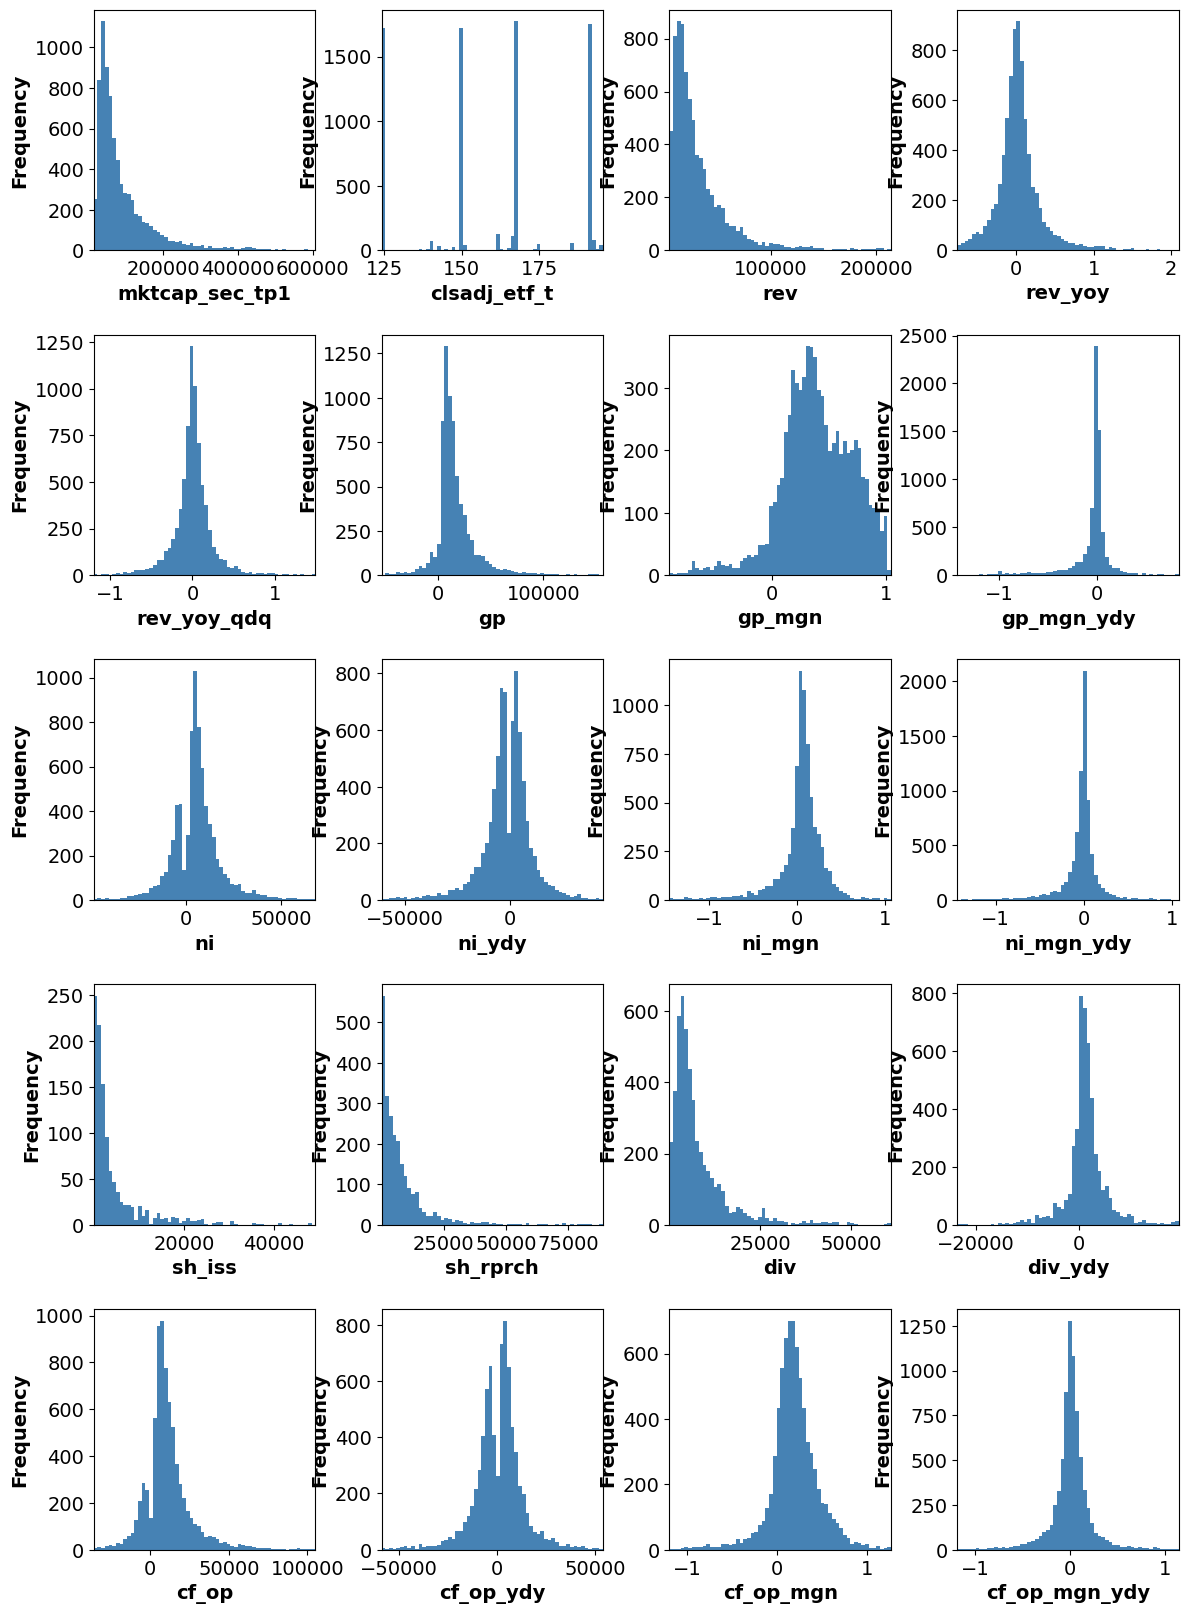

In [14]:
#histograms
fig012, axes012 = plt.subplots(nrows=5,ncols=4,figsize=(14,20))
fig012.subplots_adjust(wspace=0.3, hspace=0.35)
axes_flt012 = axes012.flatten()

is_scaled012 = df_yx_transcale012.loc[:,'scale02'] != 's21_none'

ct012 = -1
for idx012,rw012 in df_yx_transcale012.loc[is_scaled012,:].iterrows():
    
    ct012 = ct012 + 1
    feat012 = rw012['feat']
    mixflg012 = rw012['mix_flg']
    
    axes012_n = axes_flt012[ct012]
    
    #y,x data
    if mixflg012 != 'flg_none':
        is_flgset012 = df_yx_train_tran1011.loc[:,mixflg012] == 1
    else:
        is_flgset012 = df_yx_train_tran1011.index >= df_yx_train_tran1011.index.min()
    df_yxplot012 = df_yx_train_tran1011.loc[is_flgset012,[feat012]]
  
    #bins
    lwbd012 = df_yxplot012.loc[:,feat012].quantile(0.005)
    upbd012 = df_yxplot012.loc[:,feat012].quantile(0.995)
    bwdth012 = (upbd012 - lwbd012)/60
    bin_p012 = np.arange(lwbd012, upbd012 + bwdth012, bwdth012)
    axes012_n.set_xlim(lwbd012,upbd012)
    
    df_yxplot012.loc[:,feat012].plot(ax=axes012_n,kind='hist',bins=bin_p012,color='steelblue')
    axes012_n.set_xlabel(feat012, fontsize=14.0, fontweight='bold')
    axes012_n.tick_params(axis='x', labelsize=14)
    axes012_n.set_ylabel('Frequency', fontsize=14.0, fontweight='bold') 
    axes012_n.tick_params(axis='y', labelsize=14) 

plt.show()

Scatterplots of square root transformed variables (positive values, as explained above) versus revenue (also square root transformed).

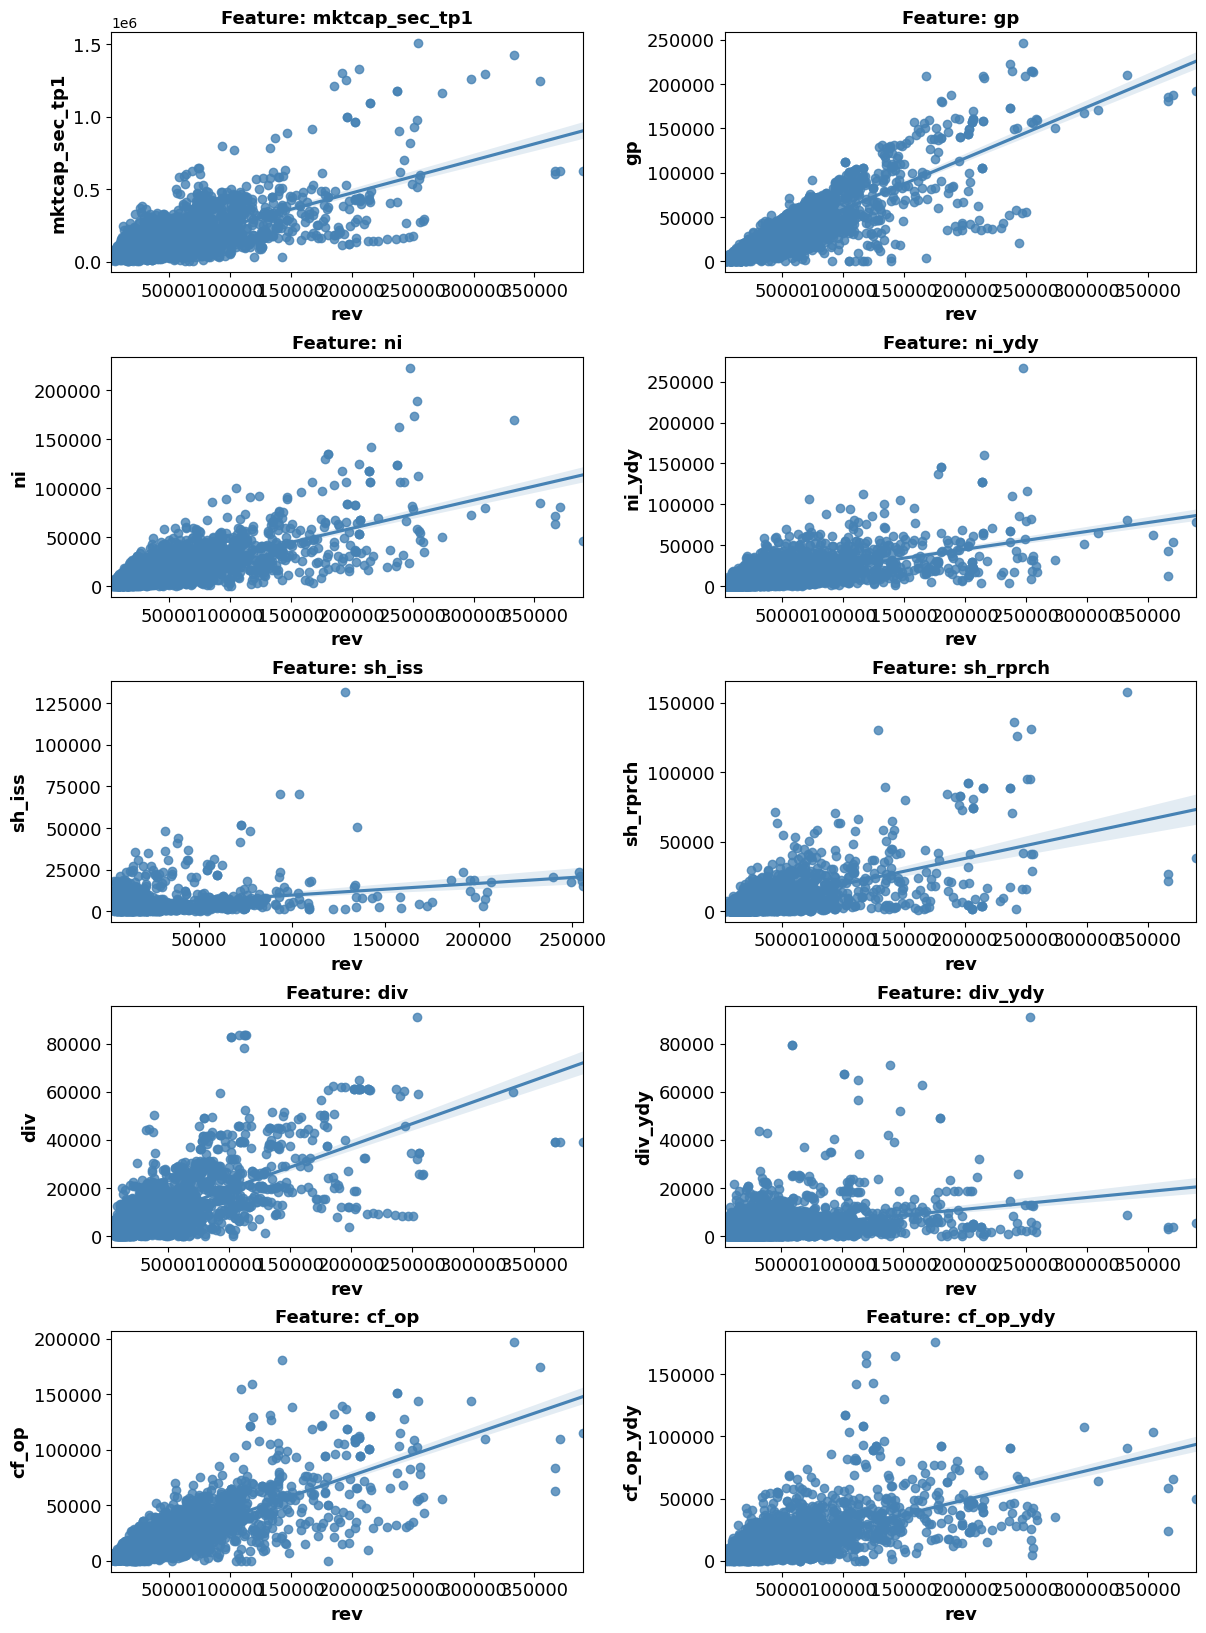

In [15]:
#scatterplots
fig011, axes011 = plt.subplots(nrows=5,ncols=2,figsize=(14,20))
fig011.subplots_adjust(wspace=0.3, hspace=0.35)
axes_flt011 = axes011.flatten()

is_revresid011 = df_yx_transcale012.loc[:,'scale01'] != 's11_none'

ct011 = -1
for idx011,rw011 in df_yx_transcale012.loc[is_revresid011,:].iterrows():
    
    ct011 = ct011 + 1
    feat011 = rw011['feat']
    mixflg011 = rw011['mix_flg']
    sc01_011 = rw011['scale01']
    
    #y,x data
    if mixflg011 != 'flg_none':
        is_flgset011 = df_yx_test_tran1011.loc[:,mixflg011] == 1
    else:
        is_flgset011 = df_yx_test_tran1011.index >= df_yx_train_tran1011.index.min()
    #df_xplot011 = df_yx_test_tran1011.loc[is_flgset011,'rev']
    #df_yplot011 = df_yx_test_tran1011.loc[is_flgset011,feat011]
    #df_yplot011 = df_yx_test_tran1011.loc[is_flgset011,feat011].abs() 
    
    if mixflg011 != 'flg_none':
        is_flgset011 = df_yx_train_tran1011.loc[:,mixflg011] == 1
    else:
        is_flgset011 = df_yx_train_tran1011.index >= df_yx_train_tran1011.index.min()
    df_xplot011 = df_yx_train_tran1011.loc[is_flgset011,'rev']
    #df_yplot011 = df_yx_train_tran1011.loc[is_flgset011,feat011]
    df_yplot011 = df_yx_train_tran1011.loc[is_flgset011,feat011].abs()


    #scatterplot
    axes011_n = axes_flt011[ct011]
    #sns.regplot(ax=axes011_n,x=df_yx_train_core011.loc[:,'rev'],y=df_yx_train_core011.loc[:,feat011]
        #,color='steelblue')
    sns.regplot(ax=axes011_n,x=df_xplot011,y=df_yplot011,color='steelblue')
    axes011_n.set_title('Feature: ' + feat011, fontsize=13.0, fontweight='bold')
    axes011_n.set_xlabel('rev', fontsize=13.0, fontweight='bold')
    axes011_n.tick_params(axis='x', labelsize=13)
    axes011_n.set_ylabel(feat011, fontsize=13.0, fontweight='bold')
    axes011_n.tick_params(axis='y', labelsize=13) 


plt.show()

Histograms of all variables after complete transformation, including scaling to have mean 0 and unit standard deviation.

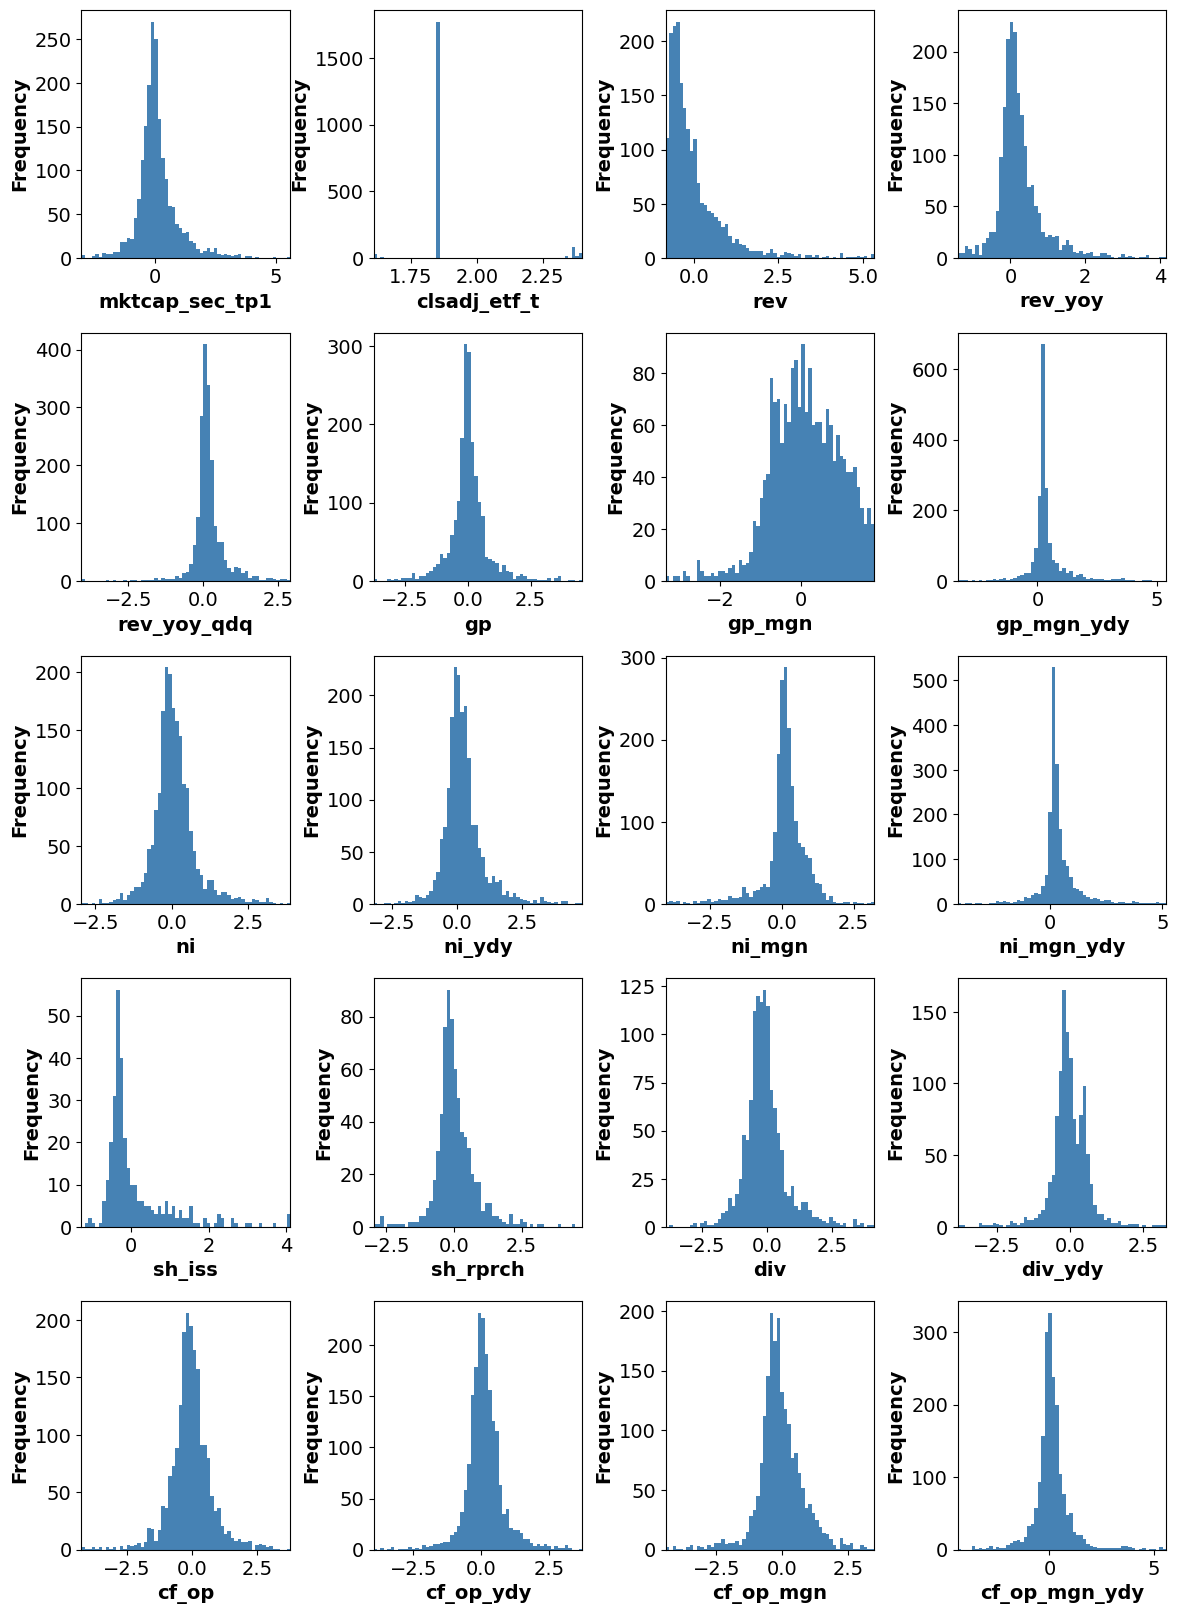

In [16]:
#histograms
fig012, axes012 = plt.subplots(nrows=5,ncols=4,figsize=(14,20))
fig012.subplots_adjust(wspace=0.4, hspace=0.3)
axes_flt012 = axes012.flatten()

is_scaled012 = df_yx_transcale012.loc[:,'scale02'] != 's21_none'

ct012 = -1
for idx012,rw012 in df_yx_transcale012.loc[is_scaled012,:].iterrows():
    
    ct012 = ct012 + 1
    feat012 = rw012['feat']
    mixflg012 = rw012['mix_flg']
    
    axes012_n = axes_flt012[ct012]
    
    #y,x data train
    if mixflg012 != 'flg_none':
        is_flgset012 = df_yx_train_tran2011.loc[:,mixflg012] == 1
    else:
        is_flgset012 = df_yx_train_tran2011.index >= df_yx_train_tran2011.index.min()
    df_yxplot012 = df_yx_train_tran2011.loc[is_flgset012,[feat012]]
    #y,x data test
    if mixflg012 != 'flg_none':
        is_flgset012 = df_yx_test_tran2011.loc[:,mixflg012] == 1
    else:
        is_flgset012 = df_yx_test_tran2011.index >= df_yx_train_tran2011.index.min()
    df_yxplot012 = df_yx_test_tran2011.loc[is_flgset012,[feat012]]  

    #bins
    lwbd012 = df_yxplot012.loc[:,feat012].quantile(0.005)
    upbd012 = df_yxplot012.loc[:,feat012].quantile(0.995)
    bwdth012 = (upbd012 - lwbd012)/60
    bin_p012 = np.arange(lwbd012, upbd012 + bwdth012, bwdth012)
    axes012_n.set_xlim(lwbd012,upbd012)
    
    df_yxplot012.loc[:,feat012].plot(ax=axes012_n,kind='hist',bins=bin_p012,color='steelblue')
    axes012_n.set_xlabel(feat012, fontsize=14.0, fontweight='bold')
    axes012_n.tick_params(axis='x', labelsize=14)
    axes012_n.set_ylabel('Frequency', fontsize=14.0, fontweight='bold') 
    axes012_n.tick_params(axis='y', labelsize=14) 

plt.show()

<b>2.2 TRAIN-TEST SPLIT</b>

Training and test data sets are defined on the transformed data using the same methodology as in the preprocessing and training notebook.

For each stock ticker, data are captured for the last 5 prior fiscal period reporting dates.  The sequence of these records are identified with column 'fisc_seq'.  The latest reporting period, identified with 'fisc_seq' == 5.0, will serve as the test data and the prior four periods, identified with 'fisc_seq' <= 4.0, will serve as the training data. Hence, the latest 20% of the data is used for testing and the prior 80% of the data is used for training.

In [17]:
#train, test data
df_x_train011 = df_yx_train_tran2011.loc[:,lst_yx_corefeat011]
df_y_train011 = df_yx_train_tran2011.loc[:,['mktcap_sec_tp1']]
df_x_test011 = df_yx_test_tran2011.loc[:,lst_yx_corefeat011]
df_y_test011 = df_yx_test_tran2011.loc[:,['mktcap_sec_tp1']]

In [18]:
df_x_train011.info()
df_y_train011.info()
df_x_test011.info()
df_y_test011.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7748 entries, 1 to 9722
Data columns (total 23 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   clsadj_etf_t   7748 non-null   float64
 1   rev            7748 non-null   float64
 2   rev_yoy        7748 non-null   float64
 3   rev_yoy_qdq    7748 non-null   float64
 4   gp_mgn_flg     7748 non-null   int64  
 5   gp             7748 non-null   float64
 6   gp_mgn         7748 non-null   float64
 7   gp_mgn_ydy     7748 non-null   float64
 8   ni             7748 non-null   float64
 9   ni_ydy         7748 non-null   float64
 10  ni_mgn         7748 non-null   float64
 11  ni_mgn_ydy     7748 non-null   float64
 12  sh_iss_flg     7748 non-null   int64  
 13  sh_iss         7748 non-null   float64
 14  sh_rprch_flg   7748 non-null   int64  
 15  sh_rprch       7748 non-null   float64
 16  div_flg        7748 non-null   int64  
 17  div            7748 non-null   float64
 18  div_ydy 

## 3 Baseline Models

In these sections I re-fit the 3 models from the preprocessing and training notebook (linear regression, xgboost decision tree, and support vector regression) on the data transformed as above.  The purpose is to assesss any impact of this different transformation on the modeling results.

<b>3.1 LINEAR REGRESSION</b>

As before, I grid search with cross validation to identify the k best features.

I evaluate all combinations of the features to identify the best subset of features to include in the linear regression model. F-statistics combined with a Lasso regression model are used to select the best subset of features (via the procedure SelectKBest). The Lasso regularization parameter and subsets of features (k best features) are evaluated using a grid search and cross validation with mean absolute error (MAE) as the scoring metric.

In [19]:
#gridsearch cross validation: best k linear regressors
nfeat021 = len(df_x_train011.columns)

#seed
np.random.seed(dttm.datetime.now().microsecond)

#grid search, cross validation 
lr_pipe021 = Pipeline( [ ('selector',SelectKBest(f_regression)), ('model',Lasso()) ] )
lr_gscv021 = GridSearchCV( estimator = lr_pipe021, param_grid = {'selector__k':list(range(1,(10+1))), 
    'model__alpha':[10]},
    scoring='neg_mean_absolute_error', cv=4, verbose=False, n_jobs=4 )

lr_pipe021 = Pipeline( [ ('selector',SelectKBest(f_regression)), ('model',LinearRegression()) ] )
lr_gscv021 = GridSearchCV( estimator = lr_pipe021, param_grid = {'selector__k':list(range(1,(10+1)))},
    scoring='neg_mean_absolute_error', cv=4, verbose=False, n_jobs=4 )
lr_gscv021.fit(df_x_train011,df_y_train011.values.ravel())

df_lr_gscv_res021 = pd.DataFrame(lr_gscv021.cv_results_)

Below are the results of the model selection for the top 10 models sorted by MAE (mean_test_score).  Models with about 7 to 9 parameters fit similarly well.

In [20]:
df_lr_gscv_res021.sort_values(by='rank_test_score').head(10)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_selector__k,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,mean_test_score,std_test_score,rank_test_score
7,0.057718,0.000271,0.018191,0.000533,8,{'selector__k': 8},-1.562954,-0.377546,-0.287097,-0.334644,-0.640560,0.533504,1
6,0.055423,0.000512,0.017874,0.000182,7,{'selector__k': 7},-1.563291,-0.379888,-0.289977,-0.332104,-0.641315,0.533253,2
8,0.058765,0.000609,0.018017,0.000296,9,{'selector__k': 9},-1.560323,-0.378019,-0.287407,-0.340255,-0.641501,0.531457,3
5,0.056323,0.001466,0.019188,0.000221,6,{'selector__k': 6},-1.578710,-0.380935,-0.292163,-0.330829,-0.645659,0.539616,4
4,0.054603,0.000756,0.018904,0.000220,5,{'selector__k': 5},-1.586009,-0.386607,-0.286654,-0.332289,-0.647890,0.542778,5
9,0.059745,0.001702,0.017001,0.001138,10,{'selector__k': 10},-1.558281,-0.379044,-0.285989,-0.373961,-0.649319,0.526092,6
3,0.054655,0.001360,0.018759,0.000673,4,{'selector__k': 4},-1.607622,-0.396851,-0.291419,-0.346612,-0.660626,0.548018,7
2,0.052677,0.000294,0.017182,0.000138,3,{'selector__k': 3},-1.610210,-0.395614,-0.292285,-0.363469,-0.665394,0.546770,8
1,0.043548,0.007646,0.015449,0.002425,2,{'selector__k': 2},-1.683913,-0.407341,-0.296546,-0.364928,-0.688182,0.576243,9
0,0.097932,0.001050,0.016949,0.000490,1,{'selector__k': 1},-1.879927,-0.403748,-0.293017,-0.377065,-0.738439,0.660304,10


Selecting a linear regression model with k = 8 features as predictor variables as the best model, I fit this model to the training data, generate predictions for the target variable using the test data, and evaluate the accuracy of the predictions.  Accuracy is assessed on the original, untransformed test data. 

In [21]:
#linear regression model: fit model with k best regressors
kbest021 = 8

#select k best regressors
lr_sel_kbest021 = SelectKBest(f_regression,k=kbest021).fit(df_x_train011,df_y_train011.values.ravel())
lr_feat_kbest021 = list(lr_sel_kbest021.get_feature_names_out())

x_kbest021 = lr_sel_kbest021.transform(df_x_train011)
df_x_kbest_train021 = df_x_train011.loc[:,lr_feat_kbest021]

#fit linear regression
lr_model_kbest021 = LinearRegression()
lr_model_kbest021.fit(df_x_kbest_train021,df_y_train011.values.ravel())

LinearRegression()

Predictions for the target variable and associated accuracy metrics are calculated on the original, untransformed data.

In [22]:
#predictions

#kbest for test set
df_x_kbest_test021 = df_x_test011.loc[:,lr_feat_kbest021]

#transformed
df_lr_model_pred021 = pd.concat([df_y_test011,pd.Series(lr_model_kbest021.predict(df_x_kbest_test021),
    index=df_x_kbest_test021.index)],axis=1)
df_lr_model_pred021.columns = ['y_obs','y_pred']

#unscaled, inverse transform
df_lr_model_pred021 = pd.concat([df_lr_model_pred021,df_yx_test_core011.loc[:,'mktcap_sec_tp1']],axis=1)
df_lr_model_pred021.rename(columns={'mktcap_sec_tp1':'mc_obs'},inplace=True)

df_lr_model_pred_temp021 = pd.concat([df_x_test011.loc[:,['rev']],df_lr_model_pred021.loc[:,['y_pred']].copy()],axis=1)
df_lr_model_pred_temp021.columns = ['rev','mktcap_sec_tp1']
lst_lr_model_pred_invtr021 = inv_transform(df_lr_model_pred_temp021,df_yx_test_featmap011,k_test011,
    df_yx_test_posneg011,df_yx_test_stats011)
df_lr_model_pred_invtran021 = lst_lr_model_pred_invtr021[0]
df_lr_model_pred_invtran021.columns = ['rev','mc_pred']

df_lr_model_pred021 = pd.concat([df_lr_model_pred021,df_lr_model_pred_invtran021.loc[:,['mc_pred']]],axis=1)

#fit metrics
df_lr_model_pred021.loc[:,'mc_resid'] = df_lr_model_pred021.loc[:,'mc_obs'] - df_lr_model_pred021.loc[:,'mc_pred']
df_lr_model_pred021.loc[:,'mc_ae'] = df_lr_model_pred021.loc[:,'mc_resid'].abs()
df_lr_model_pred021.loc[:,'mc_ape'] = df_lr_model_pred021.loc[:,'mc_ae']/df_lr_model_pred021.loc[:,'mc_obs'].abs()
df_lr_model_pred021 = pd.concat([df_sec_yxdata_core011.loc[~is_train_core_seq011,lst_yx_coreatt011],
    df_lr_model_pred021],axis=1)

df_lr_model_pred021.head(10)

,ticker,mkt_cap_202109,fisc_seq,fisc_intvl,rpt_ccy,inscope_flg,fisc_date_t,fisc_date_tm1,fisc_date_tm4,fisc_date_tm5,meas_date_tp1,y_obs,y_pred,mc_obs,mc_pred,mc_resid,mc_ae,mc_ape
0,AAPL,2.358033e+12,5.0,91.0,USD,True,2021-03-31,2020-12-31,2020-03-31,2019-12-31,2021-06-28,11.436157,5.762578,2.245600e+12,1.209637e+12,1.035963e+12,1.035963e+12,0.461330
5,MSFT,2.172555e+12,5.0,91.0,USD,True,2021-03-31,2020-12-31,2020-03-31,2019-12-31,2021-06-28,13.407820,6.453107,2.020644e+12,8.700553e+11,1.150589e+12,1.150589e+12,0.569417
10,GOOGL,1.820299e+12,5.0,91.0,USD,True,2021-03-31,2020-12-31,2020-03-31,2019-12-31,2021-06-28,10.383738,5.102617,1.644663e+12,8.305149e+11,8.141486e+11,8.141486e+11,0.495024
15,GOOG,1.820298e+12,5.0,91.0,USD,True,2021-03-31,2020-12-31,2020-03-31,2019-12-31,2021-06-28,10.699974,5.102617,1.702156e+12,8.305149e+11,8.716412e+11,8.716412e+11,0.512081
20,AMZN,1.662777e+12,5.0,91.0,USD,True,2021-03-31,2020-12-31,2020-03-31,2019-12-31,2021-06-28,7.877630,-1.157436,1.735721e+12,4.658736e+11,1.269847e+12,1.269847e+12,0.731596
25,FB,9.670962e+11,5.0,91.0,USD,True,2021-03-31,2020-12-31,2020-03-31,2019-12-31,2021-06-28,8.810701,3.655026,1.012507e+12,4.146473e+11,5.978598e+11,5.978598e+11,0.590475
30,TSLA,7.765921e+11,5.0,91.0,USD,True,2021-03-31,2020-12-31,2020-03-31,2019-12-31,2021-06-28,8.001895,-0.378210,6.632374e+11,5.085097e+10,6.123864e+11,6.123864e+11,0.923329
35,BRK-B,6.240806e+11,5.0,91.0,USD,True,2021-03-31,2020-12-31,2020-03-31,2019-12-31,2021-06-28,5.790132,3.193658,1.004905e+12,6.723805e+11,3.325240e+11,3.325240e+11,0.330901
40,NVDA,5.168906e+11,5.0,91.0,USD,True,2021-05-02,2021-01-31,2020-04-26,2020-01-26,2021-07-30,2.221054,0.484721,1.210672e+11,5.104452e+10,7.002264e+10,7.002264e+10,0.578378
45,V,5.057191e+11,5.0,91.0,USD,True,2021-03-31,2020-12-31,2020-03-31,2019-12-31,2021-06-28,6.888777,3.040001,4.558462e+11,1.637822e+11,2.920640e+11,2.920640e+11,0.640707


For the model predictions of the target variable, I calculate r-squared and absolute percent error (APE) - both mean and median.  

Interestingly, the APE metrics are substantially improved but r-squared is slightly lower relative to the linear regression model in the preprocessing and training notebook.  In particular, median-APE descreases from 60% to 47%.

In [23]:
#r-squared, mean-ape, median-ape
lr_r2 = r2_score(df_lr_model_pred021.loc[:,'mc_obs'], df_lr_model_pred021.loc[:,'mc_pred'])
lr_meanape = df_lr_model_pred021.loc[:,'mc_ape'].mean()
lr_medape = df_lr_model_pred021.loc[:,'mc_ape'].median()

df_model_testmet_smy011 = pd.DataFrame([['LR',lr_r2,lr_meanape,lr_medape]],
        columns=['model','r-squared','mean-ape','median-ape'],index=[0])
df_model_testmet_smy011

,model,r-squared,mean-ape,median-ape
0,LR,0.673865,1.758949,0.468692


<b>3.2 XGBOOST DECISION TREE </b>

In this section, I fit a boosted decision tree using the Python package xgboost.  I evaluate a set of models by cross validation with a grid search of several hyperparameters using mean absolute error (MAE) as the scoring metric.

I searched a grid across the parameter space: 
{'max_depth':[2,4,6,8],'learning_rate':[0.1,0.2,0.5],'reg_alpha':[0.5,1]}

An example of a subset of the grid search is shown below, the full grid search results are stored in a json file.

In [24]:
#XGBOOST 
#gridsearch cross validations: hyperparameters
#train data matrix
xgb_DM_train031 = xgb.DMatrix(df_x_train011,label=df_y_train011)
#parameter grid
#xgb_gscv_grid031 = {'booster':['gbtree'],'max_depth':[2,4,6,8],'learning_rate':[0.1,0.2,0.5],'reg_alpha':[0.5,1]}
xgb_gscv_grid031 = {'booster':['gbtree'],'max_depth':[6,8],'learning_rate':[0.1,0.2,0.5],'reg_alpha':[0.5,1]}
#permuations of parameter grid
keys031, values031 = zip(*xgb_gscv_grid031.items())
lst_xgb_gscv_grid031 = [dict(zip(keys031, v031)) for v031 in itool.product(*values031)]

In [25]:
lst_xgb_gscv_grid031[0:9]

[{'booster': 'gbtree', 'max_depth': 6, 'learning_rate': 0.1, 'reg_alpha': 0.5},
 {'booster': 'gbtree', 'max_depth': 6, 'learning_rate': 0.1, 'reg_alpha': 1},
 {'booster': 'gbtree', 'max_depth': 6, 'learning_rate': 0.2, 'reg_alpha': 0.5},
 {'booster': 'gbtree', 'max_depth': 6, 'learning_rate': 0.2, 'reg_alpha': 1},
 {'booster': 'gbtree', 'max_depth': 6, 'learning_rate': 0.5, 'reg_alpha': 0.5},
 {'booster': 'gbtree', 'max_depth': 6, 'learning_rate': 0.5, 'reg_alpha': 1},
 {'booster': 'gbtree', 'max_depth': 8, 'learning_rate': 0.1, 'reg_alpha': 0.5},
 {'booster': 'gbtree', 'max_depth': 8, 'learning_rate': 0.1, 'reg_alpha': 1},
 {'booster': 'gbtree', 'max_depth': 8, 'learning_rate': 0.2, 'reg_alpha': 0.5}]

In [26]:
#clock start
gscv_start031 = dttm.datetime.now()
print(gscv_start031)

#parameters
xgb_prmsbase031 = {'booster':'gbtree','max_depth':2,'learning_rate':0.1,'objective':'reg:squarederror',
    'reg_alpha':1,'reg_lambda':0,'min_child_weight':20}
n_trees_try031 = 4000
#results
df_xgb_gscv_res031 = pd.DataFrame()

ct031 = 0
for dictn031 in lst_xgb_gscv_grid031:
    ct031 = ct031 + 1
    
    #update parameters to try
    xgb_prmstry031 = xgb_prmsbase031
    for key031 in dictn031:
        xgb_prmstry031[key031] = dictn031[key031]

    #seed
    seed031 = dttm.datetime.now().microsecond
        
    df_xgb_cv031 = xgb.cv(xgb_prmstry031,xgb_DM_train031,num_boost_round=n_trees_try031,nfold=4,metrics=['mae'],
            early_stopping_rounds=30,as_pandas=True,verbose_eval=False,seed=seed031) 
    n_trees031 = len(df_xgb_cv031.index)
    df_xgb_cvinsrt031 = pd.DataFrame()
    df_xgb_cvinsrt031 = pd.concat( [ pd.DataFrame([ct031,dictn031,n_trees031]).T, df_xgb_cv031.tail(1).reset_index(drop=True) ], axis=1)
    df_xgb_cvinsrt031.columns = ['iteration','param_set','ntrees','infld-mae-mean','infld-mae-std','outfld-mae-mean','outfld-mae-std']
    
    if ct031 == 1:
        df_xgb_gscv_res031 = df_xgb_cvinsrt031.copy()
    else:
        df_xgb_gscv_res031 = pd.concat( [df_xgb_gscv_res031,df_xgb_cvinsrt031.copy()],axis=0,ignore_index=True)
    
    print(xgb_prmstry031)
    print(df_xgb_cv031.tail(1))
    
    
#clock end
gscv_end031 = dttm.datetime.now()
gscv_elapsed031 = gscv_end031 - gscv_start031
print(gscv_start031,gscv_end031,gscv_elapsed031)

2021-11-13 21:48:59.574859
{'booster': 'gbtree', 'max_depth': 6, 'learning_rate': 0.1, 'objective': 'reg:squarederror', 'reg_alpha': 0.5, 'reg_lambda': 0, 'min_child_weight': 20}
     train-mae-mean  train-mae-std  test-mae-mean  test-mae-std
513        0.122833       0.005387        0.35673      0.007983
{'booster': 'gbtree', 'max_depth': 6, 'learning_rate': 0.1, 'objective': 'reg:squarederror', 'reg_alpha': 1, 'reg_lambda': 0, 'min_child_weight': 20}
     train-mae-mean  train-mae-std  test-mae-mean  test-mae-std
446        0.132554       0.000456       0.352571      0.006489
{'booster': 'gbtree', 'max_depth': 6, 'learning_rate': 0.2, 'objective': 'reg:squarederror', 'reg_alpha': 0.5, 'reg_lambda': 0, 'min_child_weight': 20}
     train-mae-mean  train-mae-std  test-mae-mean  test-mae-std
121        0.212345       0.005412       0.365732      0.008736
{'booster': 'gbtree', 'max_depth': 6, 'learning_rate': 0.2, 'objective': 'reg:squarederror', 'reg_alpha': 1, 'reg_lambda': 0, 'min_chil

In [27]:
filnm031 = 'saved_xgb_models/df_xgb_gscv_res031_20211108.json'

#save results to json
#df_xgb_gscv_res031.to_json(filnm031) 

#load results from json
with open(filnm031) as f031:
    xgb_model_dict031 = json.load(f031)
        
df_xgb_gscv_res031 = pd.DataFrame.from_dict(xgb_model_dict031)

del f031, xgb_model_dict031

Below are the results of the model selection for the top 10 models sorted by MAE (outfld-mae-mean).  As in the preprocessing and training notebook, many of the best models fit similarly well.

In [28]:
#cross validation results
pd.set_option('display.max_colwidth',120)
df_xgb_gscv_res031.sort_values(by='outfld-mae-mean',ascending=True).head(10)

,iteration,param_set,ntrees,infld-mae-mean,infld-mae-std,outfld-mae-mean,outfld-mae-std
18,19,"{'booster': 'gbtree', 'max_depth': 8, 'learning_rate': 0.1, 'reg_alpha': 0.5}",536,0.061137,0.002964,0.353233,0.002951
13,14,"{'booster': 'gbtree', 'max_depth': 6, 'learning_rate': 0.1, 'reg_alpha': 1}",417,0.140534,0.004624,0.353561,0.013667
12,13,"{'booster': 'gbtree', 'max_depth': 6, 'learning_rate': 0.1, 'reg_alpha': 0.5}",478,0.128864,0.002504,0.356312,0.005258
19,20,"{'booster': 'gbtree', 'max_depth': 8, 'learning_rate': 0.1, 'reg_alpha': 1}",394,0.087244,0.001035,0.356362,0.011070
21,22,"{'booster': 'gbtree', 'max_depth': 8, 'learning_rate': 0.2, 'reg_alpha': 1}",169,0.107989,0.004992,0.360835,0.005892
20,21,"{'booster': 'gbtree', 'max_depth': 8, 'learning_rate': 0.2, 'reg_alpha': 0.5}",122,0.163095,0.009460,0.361781,0.010229
15,16,"{'booster': 'gbtree', 'max_depth': 6, 'learning_rate': 0.2, 'reg_alpha': 1}",211,0.141134,0.004557,0.362345,0.006464
7,8,"{'booster': 'gbtree', 'max_depth': 4, 'learning_rate': 0.1, 'reg_alpha': 1}",397,0.239684,0.007679,0.364919,0.007475
14,15,"{'booster': 'gbtree', 'max_depth': 6, 'learning_rate': 0.2, 'reg_alpha': 0.5}",248,0.128859,0.002742,0.366153,0.007892
6,7,"{'booster': 'gbtree', 'max_depth': 4, 'learning_rate': 0.1, 'reg_alpha': 0.5}",505,0.222057,0.004468,0.367482,0.009509


Based on the above cross validation results, I selected a model with the following hyperparameters for further analysis and testing,

{'booster': 'gbtree', 'max_depth': 8, 'learning_rate': 0.1, 'reg_alpha': 0.5}, ntrees=600,

again noting that many of the best models performed very similarly in cross validation.

I fit this model to the training data, generate predictions for the target variable using the test data, and evaluate the accuracy of the predictions.  Accuracy is assessed on the original, untransformed test data.

In [29]:
#{'booster': 'gbtree', 'max_depth': 8, 'learning_rate': 0.1, 'reg_alpha': 0.5}	536	0.353233	0.002951
#{'booster': 'gbtree', 'max_depth': 6, 'learning_rate': 0.1, 'reg_alpha': 1.0}	417	0.353561	0.013667
xgb_model_best031 = xgb.XGBRegressor(booster='gbtree',n_estimators=600,max_depth=8,learning_rate=0.1,
    objective='reg:squarederror',
    colsample_bynode=1.0,reg_alpha=0.5,reg_lambda=0,tree_method='auto',min_child_weight=20,
    importance_type='total_gain',random_state=dttm.datetime.now().microsecond)

xgb_model_best031.fit(df_x_train011,df_y_train011,
        eval_set=[(df_x_train011,df_y_train011)],
        eval_metric='mae', verbose=False)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1.0, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='total_gain', interaction_constraints=None,
             learning_rate=0.1, max_delta_step=0, max_depth=8,
             min_child_weight=20, missing=nan, monotone_constraints=None,
             n_estimators=600, n_jobs=0, num_parallel_tree=1,
             random_state=65203, reg_alpha=0.5, reg_lambda=0,
             scale_pos_weight=1, subsample=1, tree_method='auto',
             validate_parameters=False, verbosity=None)

Predictions for the target variable and associated accuracy metrics are calculated on the original, untransformed data.

In [30]:
#predictions
#transformed
df_xgb_model_pred031 = pd.concat([df_y_test011,pd.Series(xgb_model_best031.predict(df_x_test011),
    index=df_x_test011.index)],axis=1)
df_xgb_model_pred031.columns = ['y_obs','y_pred']

#unscaled, inverse transform
df_xgb_model_pred031 = pd.concat([df_xgb_model_pred031,df_yx_test_core011.loc[:,'mktcap_sec_tp1']],axis=1)
df_xgb_model_pred031.rename(columns={'mktcap_sec_tp1':'mc_obs'},inplace=True)

df_xgb_model_pred_temp031 = pd.concat([df_x_test011.loc[:,['rev']],df_xgb_model_pred031.loc[:,['y_pred']].copy()],axis=1)
df_xgb_model_pred_temp031.columns = ['rev','mktcap_sec_tp1']

lst_xgb_model_pred_invtr031 = inv_transform(df_xgb_model_pred_temp031,df_yx_test_featmap011,k_test011,
    df_yx_test_posneg011,df_yx_test_stats011)
df_xgb_model_pred_invtran031 = lst_xgb_model_pred_invtr031[0]
df_xgb_model_pred_invtran031.columns = ['rev','mc_pred']

df_xgb_model_pred031 = pd.concat([df_xgb_model_pred031,df_xgb_model_pred_invtran031.loc[:,['mc_pred']]],axis=1)

#fit metrics
df_xgb_model_pred031.loc[:,'mc_resid'] = df_xgb_model_pred031.loc[:,'mc_obs'] - df_xgb_model_pred031.loc[:,'mc_pred']
df_xgb_model_pred031.loc[:,'mc_ae'] = df_xgb_model_pred031.loc[:,'mc_resid'].abs()
df_xgb_model_pred031.loc[:,'mc_ape'] = df_xgb_model_pred031.loc[:,'mc_ae']/df_xgb_model_pred031.loc[:,'mc_obs'].abs()
df_xgb_model_pred031 = pd.concat([df_sec_yxdata_core011.loc[~is_train_core_seq011,lst_yx_coreatt011],
    df_xgb_model_pred031],axis=1)

df_xgb_model_pred031.head(10)

,ticker,mkt_cap_202109,fisc_seq,fisc_intvl,rpt_ccy,inscope_flg,fisc_date_t,fisc_date_tm1,fisc_date_tm4,fisc_date_tm5,meas_date_tp1,y_obs,y_pred,mc_obs,mc_pred,mc_resid,mc_ae,mc_ape
0,AAPL,2.358033e+12,5.0,91.0,USD,True,2021-03-31,2020-12-31,2020-03-31,2019-12-31,2021-06-28,11.436157,8.189653,2.245600e+12,1.613896e+12,6.317038e+11,6.317038e+11,0.281307
5,MSFT,2.172555e+12,5.0,91.0,USD,True,2021-03-31,2020-12-31,2020-03-31,2019-12-31,2021-06-28,13.407820,11.257245,2.020644e+12,1.613833e+12,4.068117e+11,4.068117e+11,0.201328
10,GOOGL,1.820299e+12,5.0,91.0,USD,True,2021-03-31,2020-12-31,2020-03-31,2019-12-31,2021-06-28,10.383738,8.329022,1.644663e+12,1.295167e+12,3.494966e+11,3.494966e+11,0.212503
15,GOOG,1.820298e+12,5.0,91.0,USD,True,2021-03-31,2020-12-31,2020-03-31,2019-12-31,2021-06-28,10.699974,8.329022,1.702156e+12,1.295167e+12,4.069892e+11,4.069892e+11,0.239102
20,AMZN,1.662777e+12,5.0,91.0,USD,True,2021-03-31,2020-12-31,2020-03-31,2019-12-31,2021-06-28,7.877630,5.040902,1.735721e+12,1.250199e+12,4.855212e+11,4.855212e+11,0.279723
25,FB,9.670962e+11,5.0,91.0,USD,True,2021-03-31,2020-12-31,2020-03-31,2019-12-31,2021-06-28,8.810701,7.850972,1.012507e+12,8.813292e+11,1.311778e+11,1.311778e+11,0.129557
30,TSLA,7.765921e+11,5.0,91.0,USD,True,2021-03-31,2020-12-31,2020-03-31,2019-12-31,2021-06-28,8.001895,0.990398,6.632374e+11,1.034763e+11,5.597611e+11,5.597611e+11,0.843983
35,BRK-B,6.240806e+11,5.0,91.0,USD,True,2021-03-31,2020-12-31,2020-03-31,2019-12-31,2021-06-28,5.790132,4.210996,1.004905e+12,7.947351e+11,2.101694e+11,2.101694e+11,0.209144
40,NVDA,5.168906e+11,5.0,91.0,USD,True,2021-05-02,2021-01-31,2020-04-26,2020-01-26,2021-07-30,2.221054,1.378926,1.210672e+11,8.338726e+10,3.767989e+10,3.767989e+10,0.311231
45,V,5.057191e+11,5.0,91.0,USD,True,2021-03-31,2020-12-31,2020-03-31,2019-12-31,2021-06-28,6.888777,5.684076,4.558462e+11,3.486976e+11,1.071485e+11,1.071485e+11,0.235054


As above for the linear regression model, for the model predictions of the target variable I calculate r-squared and absolute percent error (APE) - both mean and median.  

Relative to the preprocessing and training notebook all three metrics are substantially improved.  In particular, median-APE descreases from 62% to 40%, a 22% incremental improvement.

In [31]:
#r-squared, mean-ape, median-ape
xgb_r2 = r2_score(df_xgb_model_pred031.loc[:,'mc_obs'], df_xgb_model_pred031.loc[:,'mc_pred'])
xgb_meanape = df_xgb_model_pred031.loc[:,'mc_ape'].mean()
xgb_medape = df_xgb_model_pred031.loc[:,'mc_ape'].median()

df_model_testmet_smy011 = df_model_testmet_smy011.loc[df_model_testmet_smy011.index<=0,:]
df_model_testmet_smy011 = df_model_testmet_smy011.append(pd.Series(['XGB',xgb_r2,xgb_meanape,xgb_medape],
    index=df_model_testmet_smy011.columns),ignore_index=True)
df_model_testmet_smy011

,model,r-squared,mean-ape,median-ape
0,LR,0.673865,1.758949,0.468692
1,XGB,0.891455,1.512398,0.398378


<b>3.3 SUPPORT VECTOR REGRESSION </b>

In this section, I fit a support vector regression model.  I evaluate a set of models by cross validation with a grid search of several hyperparameters using mean absolute error (MAE) as the scoring metric.

Here, I perform cross validation with a grid search over hyperparameters C, gamma, and epsilon.  Models are fit using the radial basis function as a nonlinear kernel and mean absolute error (MAE) as the scoring metric.  I searched many iterations over the hyperparameter space to identify the best-fit model.  

I searched extensively in the grid across the space of hyperparameters C, gamma and epsilon. The fuller grid search results are stored in a json file.

An example of a subset of the grid search in the neighborhood of the parameters selected for the best model is shown below.

In [32]:
#SUPPORT VECTOR REGRESSION
### gridsearch cross validation
#clock start
gscv_start041 = dttm.datetime.now()
print(gscv_start041)

svr_model041 = SVR(kernel='rbf')
  
#svr_gscv_grid041 = {'kernel':['rbf'],
    #'C':[0.100,0.200,0.340,0.500,0.800],'gamma':[0.010,0.020,0.130,0.200,0.500],
    #'epsilon':[0.00005,0.0001,0.0002,0.0005,0.001]}

svr_gscv_grid041 = {'kernel':['rbf'],
    'C':[0.200,0.340,0.500],'gamma':[0.020,0.130,0.200],
    'epsilon':[0.0001,0.0005,0.001]}

svr_gscv041 = GridSearchCV( estimator = svr_model041, param_grid = svr_gscv_grid041,
    scoring='neg_mean_absolute_error', cv=4, verbose=2, n_jobs=4 )
svr_gscv041.fit(df_x_train011,df_y_train011.values.ravel())

#clock end
gscv_end041 = dttm.datetime.now()
gscv_elapsed041 = gscv_end041 - gscv_start041
print(gscv_start041,gscv_end041,gscv_elapsed041)

2021-11-13 22:13:03.972923
Fitting 4 folds for each of 27 candidates, totalling 108 fits
2021-11-13 22:13:03.972923 2021-11-13 22:22:56.122942 0:09:52.150019


In [33]:
filnm041 = 'saved_svr_models/df_svr_gscv_res041_20211108.json'

#save results to json
#df_svr_gscv_res041.to_json(filnm041) 

#load results from json
with open(filnm041) as f041:
    svr_model_dict041 = json.load(f041)
        
df_svr_gscv_res041 = pd.DataFrame.from_dict(svr_model_dict041)

del f041, svr_model_dict041

Below are the results of the model selection for the top 10 models sorted by MAE (mean_test_score).  

In [34]:
pd.set_option('display.max_colwidth',80)
df_svr_gscv_res041.sort_values(by='rank_test_score').head(10)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_epsilon,param_gamma,param_kernel,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,mean_test_score,std_test_score,rank_test_score
57,11.269983,0.308661,6.387394,0.009681,0.34,0.00010,0.13,rbf,"{'C': 0.34, 'epsilon': 0.0001, 'gamma': 0.13, 'kernel': 'rbf'}",-1.264593,-0.362121,-0.226572,-0.272043,-0.531332,0.426149,1
62,11.414728,0.344720,6.448948,0.105406,0.34,0.00020,0.13,rbf,"{'C': 0.34, 'epsilon': 0.0002, 'gamma': 0.13, 'kernel': 'rbf'}",-1.264633,-0.362134,-0.226570,-0.272064,-0.531350,0.426162,2
52,11.250812,0.314448,6.448374,0.113411,0.34,0.00005,0.13,rbf,"{'C': 0.34, 'epsilon': 5e-05, 'gamma': 0.13, 'kernel': 'rbf'}",-1.264632,-0.362139,-0.226578,-0.272062,-0.531353,0.426161,3
67,11.205310,0.297020,6.484259,0.056181,0.34,0.00050,0.13,rbf,"{'C': 0.34, 'epsilon': 0.0005, 'gamma': 0.13, 'kernel': 'rbf'}",-1.264665,-0.362112,-0.226550,-0.272099,-0.531356,0.426177,4
72,11.131226,0.279525,6.449644,0.093727,0.34,0.00100,0.13,rbf,"{'C': 0.34, 'epsilon': 0.001, 'gamma': 0.13, 'kernel': 'rbf'}",-1.264742,-0.362113,-0.226543,-0.272094,-0.531373,0.426212,5
97,11.975932,0.420506,6.477541,0.178128,0.50,0.00100,0.13,rbf,"{'C': 0.5, 'epsilon': 0.001, 'gamma': 0.13, 'kernel': 'rbf'}",-1.263398,-0.362730,-0.229470,-0.272759,-0.532089,0.424949,6
82,12.339093,0.439220,6.404688,0.014838,0.50,0.00010,0.13,rbf,"{'C': 0.5, 'epsilon': 0.0001, 'gamma': 0.13, 'kernel': 'rbf'}",-1.263391,-0.362765,-0.229423,-0.272825,-0.532101,0.424940,7
92,12.059924,0.455275,6.383172,0.016290,0.50,0.00050,0.13,rbf,"{'C': 0.5, 'epsilon': 0.0005, 'gamma': 0.13, 'kernel': 'rbf'}",-1.263426,-0.362749,-0.229449,-0.272835,-0.532115,0.424951,8
77,12.192079,0.482323,6.416887,0.039655,0.50,0.00005,0.13,rbf,"{'C': 0.5, 'epsilon': 5e-05, 'gamma': 0.13, 'kernel': 'rbf'}",-1.263399,-0.362770,-0.229434,-0.272856,-0.532115,0.424937,9
87,12.145913,0.419531,6.396146,0.010342,0.50,0.00020,0.13,rbf,"{'C': 0.5, 'epsilon': 0.0002, 'gamma': 0.13, 'kernel': 'rbf'}",-1.263433,-0.362771,-0.229426,-0.272854,-0.532121,0.424953,10


Based on the above cross validation results, I selected a model with the following hyperparameters for further analysis and testing,

kernel='rbf', C=0.34, gamma=0.0001, epsilon=0.13,

noting that many of the best models performed very similarly in cross validation.

I fit this model to the training data, generate predictions for the target variable using the test data, and evaluate the accuracy of the predictions.  Accuracy is assessed on the original, untransformed test data. 

In [35]:
#support vector regression - best model

#RBF KERNEL
#{'kernel':['rbf'],'C':[0.100,0.200,0.340,0.500,0.800],'gamma':[0.010,0.020,0.130,0.200,0.500],
    #'epsilon':[0.00005,0.0001,0.0002,0.0005,0.001]}
#C=34, gamma=0.13, epsilon=0.0001; MAE -0.531332

svr_model_best041 = SVR(kernel='rbf', C=0.340, gamma=0.130, epsilon=0.0001)    
svr_model_best041.fit(df_x_train011,df_y_train011.values.ravel())

SVR(C=0.34, epsilon=0.0001, gamma=0.13)

Predictions for the target variable and associated accuracy metrics are calculated on the original, untransformed data.

In [36]:
#predictions
#transformed
df_svr_model_pred041 = pd.concat([df_y_test011,pd.Series(svr_model_best041.predict(df_x_test011),
    index=df_x_test011.index)],axis=1)
df_svr_model_pred041.columns = ['y_obs','y_pred']

#unscaled, inverse transform
df_svr_model_pred041 = pd.concat([df_svr_model_pred041,df_yx_test_core011.loc[:,'mktcap_sec_tp1']],axis=1)
df_svr_model_pred041.rename(columns={'mktcap_sec_tp1':'mc_obs'},inplace=True)

df_svr_model_pred_temp041 = pd.concat([df_x_test011.loc[:,['rev']],df_svr_model_pred041.loc[:,['y_pred']].copy()],axis=1)
df_svr_model_pred_temp041.columns = ['rev','mktcap_sec_tp1']

lst_svr_model_pred_invtr041 = inv_transform(df_svr_model_pred_temp041,df_yx_test_featmap011,k_test011,
    df_yx_test_posneg011,df_yx_test_stats011)
df_svr_model_pred_invtran041 = lst_svr_model_pred_invtr041[0]
df_svr_model_pred_invtran041.columns = ['rev','mc_pred']

df_svr_model_pred041 = pd.concat([df_svr_model_pred041,df_svr_model_pred_invtran041.loc[:,['mc_pred']]],axis=1)

#fit metrics
df_svr_model_pred041.loc[:,'mc_resid'] = df_svr_model_pred041.loc[:,'mc_obs'] - df_svr_model_pred041.loc[:,'mc_pred']
df_svr_model_pred041.loc[:,'mc_ae'] = df_svr_model_pred041.loc[:,'mc_resid'].abs()
df_svr_model_pred041.loc[:,'mc_ape'] = df_svr_model_pred041.loc[:,'mc_ae']/df_svr_model_pred041.loc[:,'mc_obs'].abs()
df_svr_model_pred041 = pd.concat([df_sec_yxdata_core011.loc[~is_train_core_seq011,lst_yx_coreatt011],
    df_svr_model_pred041],axis=1)

df_svr_model_pred041.head(10)

,ticker,mkt_cap_202109,fisc_seq,fisc_intvl,rpt_ccy,inscope_flg,fisc_date_t,fisc_date_tm1,fisc_date_tm4,fisc_date_tm5,meas_date_tp1,y_obs,y_pred,mc_obs,mc_pred,mc_resid,mc_ae,mc_ape
0,AAPL,2.358033e+12,5.0,91.0,USD,True,2021-03-31,2020-12-31,2020-03-31,2019-12-31,2021-06-28,11.436157,-0.090749,2.245600e+12,4.740407e+11,1.771559e+12,1.771559e+12,0.788902
5,MSFT,2.172555e+12,5.0,91.0,USD,True,2021-03-31,2020-12-31,2020-03-31,2019-12-31,2021-06-28,13.407820,0.128907,2.020644e+12,2.384850e+11,1.782159e+12,1.782159e+12,0.881976
10,GOOGL,1.820299e+12,5.0,91.0,USD,True,2021-03-31,2020-12-31,2020-03-31,2019-12-31,2021-06-28,10.383738,-0.071026,1.644663e+12,3.000413e+11,1.344622e+12,1.344622e+12,0.817567
15,GOOG,1.820298e+12,5.0,91.0,USD,True,2021-03-31,2020-12-31,2020-03-31,2019-12-31,2021-06-28,10.699974,-0.071026,1.702156e+12,3.000413e+11,1.402115e+12,1.402115e+12,0.823729
20,AMZN,1.662777e+12,5.0,91.0,USD,True,2021-03-31,2020-12-31,2020-03-31,2019-12-31,2021-06-28,7.877630,-0.091845,1.735721e+12,5.737022e+11,1.162018e+12,1.162018e+12,0.669473
25,FB,9.670962e+11,5.0,91.0,USD,True,2021-03-31,2020-12-31,2020-03-31,2019-12-31,2021-06-28,8.810701,0.104088,1.012507e+12,1.555492e+11,8.569578e+11,8.569578e+11,0.846372
30,TSLA,7.765921e+11,5.0,91.0,USD,True,2021-03-31,2020-12-31,2020-03-31,2019-12-31,2021-06-28,8.001895,-0.552204,6.632374e+11,4.548605e+10,6.177513e+11,6.177513e+11,0.931418
35,BRK-B,6.240806e+11,5.0,91.0,USD,True,2021-03-31,2020-12-31,2020-03-31,2019-12-31,2021-06-28,5.790132,-0.095049,1.004905e+12,3.467820e+11,6.581226e+11,6.581226e+11,0.654911
40,NVDA,5.168906e+11,5.0,91.0,USD,True,2021-05-02,2021-01-31,2020-04-26,2020-01-26,2021-07-30,2.221054,0.701151,1.210672e+11,5.814823e+10,6.291893e+10,6.291893e+10,0.519703
45,V,5.057191e+11,5.0,91.0,USD,True,2021-03-31,2020-12-31,2020-03-31,2019-12-31,2021-06-28,6.888777,0.541190,4.558462e+11,5.248774e+10,4.033584e+11,4.033584e+11,0.884856


As above for the other models, for the model predictions of the target variable I calculate r-squared and absolute percent error (APE) - both mean and median.  

Interestingly, relative to the preprocessing and training notebook, the model performance here is worse across all metrics relative to the SVR model in the preprocessing and training notebooks, with r-squared substantially lower and median-APE slightly higher - increasing slightly to 43% from 41%.

In [37]:
#r-squared, mean-ape, median-ape
svr_r2 = r2_score(df_svr_model_pred041.loc[:,'mc_obs'], df_svr_model_pred041.loc[:,'mc_pred'])
svr_meanape = df_svr_model_pred041.loc[:,'mc_ape'].mean()
svr_medape = df_svr_model_pred041.loc[:,'mc_ape'].median()

df_model_testmet_smy011 = df_model_testmet_smy011.loc[df_model_testmet_smy011.index<=1,:]
df_model_testmet_smy011 = df_model_testmet_smy011.append(pd.Series(['SVR',svr_r2,svr_meanape,svr_medape],
    index=df_model_testmet_smy011.columns),ignore_index=True)
df_model_testmet_smy011

,model,r-squared,mean-ape,median-ape
0,LR,0.673865,1.758949,0.468692
1,XGB,0.891455,1.512398,0.398378
2,SVR,0.359517,1.504365,0.427169


<b>3.4 FEATURE IMPORTANCE: BASELINE MODELS</b>

In this section, I do a brief further comparison of feature importance among the 3 baseline models with the same methodology as in the preprocessing and training notebook.  These results are commented on in the conclusions of this section.

In [38]:
#feature importance - linear regression
lr_featimp_std021 = lr_model_kbest021.coef_*np.array(df_x_kbest_train021.std())
lr_featimp021 = lr_featimp_std021/np.sum(np.abs(lr_featimp_std021))

df_lr_model_featimp021 = pd.concat([pd.Series(df_x_kbest_train021.columns),pd.Series(lr_featimp021).abs(),
    pd.Series(lr_featimp021)], axis=1)
df_lr_model_featimp021.columns = ['feature','importance_abs','importance']
df_lr_model_featimp021.sort_values(by='importance_abs',ascending=False,inplace=True)
df_lr_model_featimp021.reset_index(inplace=True)
df_lr_model_featimp021.columns = ['idx_feat','feat_label','importance_abs','importance']
df_lr_model_featimp021

,idx_feat,feat_label,importance_abs,importance
0,5,div,0.276779,0.276779
1,4,sh_rprch,0.212112,0.212112
2,2,ni,0.151605,0.151605
3,6,cf_op,0.128901,0.128901
4,0,gp,0.090681,0.090681
5,1,gp_mgn,0.086811,0.086811
6,3,ni_mgn,0.041254,-0.041254
7,7,cf_op_mgn,0.011857,-0.011857


In [39]:
#feature importance - xgboost decision tree
df_xgb_model_featimp031 = pd.concat([pd.Series(df_x_train011.columns),pd.Series(xgb_model_best031.feature_importances_)],
    axis=1)
df_xgb_model_featimp031.columns = ['feature','importance']
df_xgb_model_featimp031.sort_values(by='importance',ascending=False,inplace=True)
df_xgb_model_featimp031.reset_index(inplace=True)
df_xgb_model_featimp031.columns = ['idx_feat','feat_label','importance']
df_xgb_model_featimp031

,idx_feat,feat_label,importance
0,1,rev,0.155001
1,17,div,0.140257
2,15,sh_rprch,0.125668
3,8,ni,0.124781
4,10,ni_mgn,0.056991
5,5,gp,0.056786
6,6,gp_mgn,0.054158
7,19,cf_op,0.050698
8,2,rev_yoy,0.045828
9,21,cf_op_mgn,0.032736


In [40]:
#feature importance - perturbations - support vector regression

#features
n_corefeat041 = len(lst_yx_corefeat011)
#support vectors
df_x_sv_best041 = pd.DataFrame(svr_model_best041.support_vectors_,index=list(svr_model_best041.support_),
        columns=df_x_train011.columns)
#y for support vectors
df_y_sv_best041 = pd.DataFrame(svr_model_best041.predict(df_x_sv_best041),
    index=df_x_sv_best041.index,columns=['y_pred'])

for ct041 in range(0,n_corefeat041):
    
    #feature label
    coln041 = lst_yx_corefeat011[ct041]
    
    #perturbation by %
    df_x_sv_best_pbit041 = df_x_sv_best041.copy()
    df_x_sv_best_pbit041.iloc[:,ct041] = df_x_sv_best_pbit041.iloc[:,ct041]*1.01
    
    #calc y (x+bit), y delta
    df_y_sv_best_pbit041 = pd.DataFrame(svr_model_best041.predict(df_x_sv_best_pbit041),
        index=df_x_sv_best_pbit041.index,columns=['y_pred'])
    df_y_sv_best_deltinsrt041 = pd.DataFrame(columns=[coln041])
    df_y_sv_best_deltinsrt041 = df_y_sv_best_pbit041.loc[:,'y_pred'] - df_y_sv_best041.loc[:,'y_pred']
    
    #save
    if ct041 == 0:
        df_y_sv_best_delt041 = df_y_sv_best_deltinsrt041
    else:
        df_y_sv_best_delt041 = pd.concat([df_y_sv_best_delt041,df_y_sv_best_deltinsrt041],ignore_index=True,axis=1)
        

In [41]:
#feature importance - support vector regression
df_svr_featimp041 = pd.DataFrame(columns=['feat_label','y_delta_avg','y_deltaabs_avg'])
df_svr_featimp041.loc[:,'feat_label'] = pd.Series(lst_yx_corefeat011)
#mean delta
df_svr_featimp041.loc[:,'y_delta_avg'] = df_y_sv_best_delt041.mean()
#mean delta abs
df_svr_featimp041.loc[:,'y_deltaabs_avg'] = df_y_sv_best_delt041.abs().mean()
#mean delta, relative
df_svr_featimp041.loc[:,'y_delta_relavg'] = df_svr_featimp041.loc[:,'y_delta_avg']/df_svr_featimp041.loc[:,'y_deltaabs_avg'].sum()
#mean delta abs, relative
df_svr_featimp041.loc[:,'y_deltaabs_relavg'] = df_svr_featimp041.loc[:,'y_deltaabs_avg']/df_svr_featimp041.loc[:,'y_deltaabs_avg'].sum()

#idx_feat	feat_label	importance
df_svr_featimp041.rename(columns={'y_deltaabs_relavg':'importance'},inplace=True)
df_svr_featimp041.sort_values(by='importance',ascending=False,inplace=True)

df_svr_featimp041.head(19)

,feat_label,y_delta_avg,y_deltaabs_avg,y_delta_relavg,importance
1,rev,-0.000190,0.000896,-0.018252,0.085824
17,div,-0.000148,0.000810,-0.014206,0.077590
16,div_flg,0.000040,0.000752,0.003869,0.072066
0,clsadj_etf_t,-0.000315,0.000711,-0.030204,0.068105
8,ni,-0.000105,0.000685,-0.010077,0.065649
6,gp_mgn,-0.000319,0.000677,-0.030572,0.064856
4,gp_mgn_flg,0.000611,0.000652,0.058519,0.062454
10,ni_mgn,0.000134,0.000549,0.012870,0.052586
5,gp,-0.000319,0.000538,-0.030618,0.051522
2,rev_yoy,-0.000007,0.000486,-0.000698,0.046583


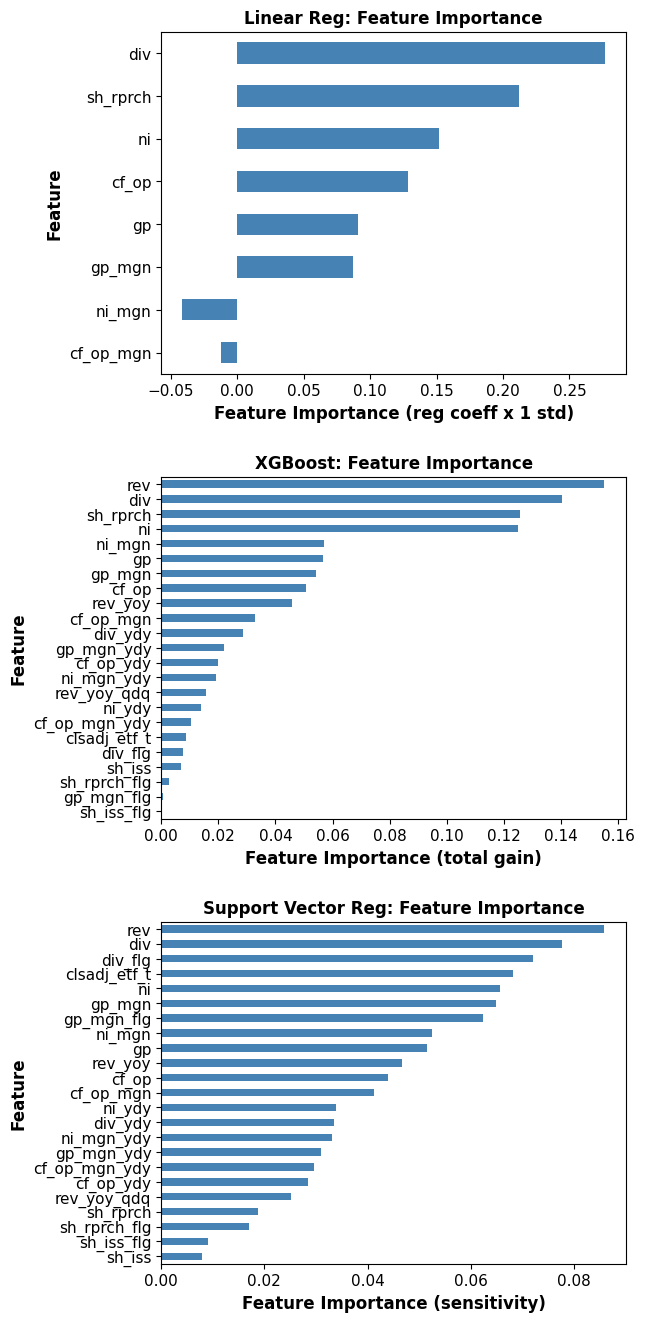

In [42]:
#plot horizontal bars
fig034, axes034 = plt.subplots(nrows=3,ncols=1,figsize=(6,16))
fig034.subplots_adjust(hspace=0.3)
axes_flt034 = axes034.flatten()

lst_df_feat034 = [df_lr_model_featimp021.sort_values(by='importance_abs'),
                  df_xgb_model_featimp031.sort_values(by='importance'),
                  df_svr_featimp041.sort_values(by='importance')]
lst_feat_title034 = ['Linear Reg: Feature Importance','XGBoost: Feature Importance',
    'Support Vector Reg: Feature Importance']
lst_feat_xlabel034 = ['Feature Importance (reg coeff x 1 std)','Feature Importance (total gain)',
    'Feature Importance (sensitivity)']

for ct034 in range(0,3):
    
    lst_df_feat034[ct034].plot.barh(ax=axes_flt034[ct034],x='feat_label',y='importance',rot=0,
            color='steelblue')

    axes_flt034[ct034].set_title(lst_feat_title034[ct034], fontsize = 12, fontweight='bold')
    axes_flt034[ct034].set_xlabel(lst_feat_xlabel034[ct034], fontsize = 12, fontweight='bold')
    axes_flt034[ct034].tick_params(axis='x', labelsize=11)
    axes_flt034[ct034].set_ylabel('Feature', fontsize = 12, fontweight='bold') 
    axes_flt034[ct034].tick_params(axis='y', labelsize=11)
    axes_flt034[ct034].get_legend().remove()
    

plt.show()

<b>BASELINE MODELS: CONCLUSIONS</b>

This analysis suggests the following conclusions for the baseline models.

<ol type="1">
  <li>The additional feature engineering transformations implemented in this notebook substantially impacted model accuracy on the test data relative to the results in the preprocessing and training notebook.</li>
  <li>Median-APE is substantially improved for the linear regression and xgboost decision tree models, but median-APE is slightly worse for the support vector regression model.</li>
  <li>The overall best model in terms of median-APE is the xgboost decision tree model with a value of 39.8%, which, interestingly, is only slightly better than the support vector regression model from the preprocessing and training notebook with a median-APE of 40.8%.</li>
  <li>A final notable result is that the 3 models differ fairly substantially in terms of feature importance in the analysis here and compared to the results in the preprocessing and training notebook.  There are a variety of differences.  One primary difference is revenue, which is the top feature in the xgboost decision tree and support vector regression models, but not present as a top feature in the linear regression model.  Another example is share repurchase amount, which has high importance in the linear regression and xgboost tree models but much lower importance in the support vector regression model.  A further observation is that there are some key similarities: dividend, net income, gross profit, and gross profit margin all rank fairly high in all three models. Finally, the top 4 features in the xgboost decision tree model are substantially more important relative to other features, but in contrast, in the support vector regression the relative importance of all features is much more evenly distributed.  Clearly there is a lot of detail yet to be understood in terms of how these different features might predict market capitalization. </li>  
  <li>These results demonstrate the impact of feature engineering on modeling results.</li> 
</ol> 

## 4 Neural Network Models

In this section, I apply some basic neural networks models to assess whether these additional models can improve upon the models already described.

<b>4.0 TENSOR DATA, FUNCTIONS</b>

Here, I define training and test data sets in terms of tensors and create two functions to facilitate the building and fitting of some basic neural network models.  

The neural network models I consider have the same basic structure consisting to two main components: (i) a linear layer that consumers features as inputs and then sends its outputs to the final output layers, and (ii) a nonlinear model of three sequential nonlinear layers that consumes features as input and also consumes the linear layer output as input before then sending its outputs to the the final output layer.  The outputs of the linear and nonlinear components are then concatenated into the final output node.  

In this architecture, the model has an explicit linear component that feeds directly to the output as well as a nonlinear layer that consumes both features directly and the linear outputs directly.  Hence, the final node is a sum of the linear and nonlinear component models.  The idea behind this architecture is to include an explicit linear model to capture the linear effects of features and then supplement this linear model with a nonlinear model to capture any nonlinear effects.

The models have separate L1 regularization hyperparameters for the linear and nonlinear layers and I use these regularization hyperparameters in an attempt to build models that are more or less weighted towards the linear and nonlinear components of the model.

In [43]:
#dataframe to tensor
tsr_x_train011 = tf.convert_to_tensor(df_x_train011)
tsr_y_train011 = tf.convert_to_tensor(df_y_train011)
tsr_x_test011 = tf.convert_to_tensor(df_x_test011)
tsr_y_test011 = tf.convert_to_tensor(df_y_test011)

In [44]:
#NN Model: Linear + NonLinear LinNLinMerge 3-Layer Model

def nn_linnlin_build(df_transtats,inpt_shape,l1_reg_lin,l1_reg_nlin):
    #inputs
    #get mkt cap b0,b1
    is_stats_mc = df_transtats.loc[:,'feat'] == 'mktcap_sec_tp1'
    df_transtats.loc[is_stats_mc,:]
    b0_mc = df_transtats.loc[is_stats_mc,:].iloc[0,1]
    b1_mc = df_transtats.loc[is_stats_mc,:].iloc[0,2]
    #x data
    nn_input01 = keras.Input(shape=inpt_shape,name='input')
    x_rev = tf.gather(nn_input01,[1],axis=1)
    
    #layer 1
    lay_lin01 = layers.Dense(1, activation='linear',
        kernel_initializer=keras.initializers.RandomUniform(minval=-2, maxval=2, seed=dttm.datetime.now().microsecond), 
        bias_initializer='zeros',
        kernel_regularizer=keras.regularizers.L1(l1=l1_reg_lin), 
        bias_regularizer=keras.regularizers.L1(l1=l1_reg_lin),name='lin1')(nn_input01)
    lay_01 = layers.concatenate([nn_input01,lay_lin01],name='in_lin1_concat')

    #layer 2
    lay_nonlin02 = layers.Dense(30, activation='relu', 
        kernel_initializer=keras.initializers.RandomUniform(minval=-1, maxval=1, seed=dttm.datetime.now().microsecond), 
        bias_initializer='zeros',
        kernel_regularizer=keras.regularizers.L1(l1=l1_reg_nlin), 
        bias_regularizer=keras.regularizers.L1(l1=l1_reg_nlin),name='nlin1')(lay_01)

    #layer 3
    lay_nonlin03 = layers.Dense(20, activation='relu',
        kernel_initializer=keras.initializers.RandomUniform(minval=-1, maxval=1, seed=dttm.datetime.now().microsecond), 
        bias_initializer='zeros',
        kernel_regularizer=keras.regularizers.L1(l1=l1_reg_nlin), 
        bias_regularizer=keras.regularizers.L1(l1=l1_reg_nlin),name='nlin2')(lay_nonlin02)

    #layer 4
    lay_nonlin04 = layers.Dense(10, activation='relu',
        kernel_initializer=keras.initializers.RandomUniform(minval=-1, maxval=1, seed=dttm.datetime.now().microsecond), 
        bias_initializer='zeros',
        kernel_regularizer=keras.regularizers.L1(l1=l1_reg_nlin), 
        bias_regularizer=keras.regularizers.L1(l1=l1_reg_nlin),name='nlin3')(lay_nonlin03)
    lay_04 = layers.concatenate([lay_lin01,lay_nonlin04],name='lin_nlin_concat')

    #output - linear y=x
    y_preout = layers.Dense(1, activation='linear', use_bias=False, kernel_initializer='Ones', 
        trainable=False,name='y_preout')(lay_04)
    #constrain y above ( -(b0+b1*rev) )
    #calc y + b0 + b1*x
    b01b1x_rev = layers.Lambda(lambda x: b0_mc + b1_mc*x)(x_rev)
    y_shift_b01b1x_rev = tf.keras.layers.Add()([y_preout, b01b1x_rev])
    y_shift_pos = keras.layers.maximum([tf.zeros_like(y_shift_b01b1x_rev),y_shift_b01b1x_rev])
    y_shift_pos_ind = layers.Lambda(lambda x: tf.math.sign(x))(y_shift_pos)
    y_out = keras.layers.Multiply(name='y_out')([y_shift_pos_ind, y_preout])

    #model
    nn_model = keras.Model(inputs=nn_input01, outputs=y_out, name='nn_linnlin')
    
    return nn_model 


In [45]:
#NN Model Fit
def nn_model_fit(x_train,y_train,nn_model,optmethod,n_epoch,vrb,chkpt_path,erlstp_pat):
    
    #callbacks
    chkpt = keras.callbacks.ModelCheckpoint(filepath=chkpt_path, save_weights_only=False, 
        monitor='val_mean_absolute_error', mode='min', save_best_only=True)
    erlstp = keras.callbacks.EarlyStopping(monitor='loss', patience=erlstp_pat, mode='min')
    #compile
    nn_model.compile(optimizer=optmethod, loss=keras.losses.MeanAbsoluteError(), 
        metrics=keras.metrics.MeanAbsoluteError())
    #fit
    nn_model_hist = nn_model.fit(x=x_train,y=y_train, epochs=n_epoch, verbose=vrb, 
        validation_split=0.25, callbacks=[chkpt,erlstp])
    
    return [nn_model_hist, chkpt_path]

<b>4.1 NEURAL NETWORK MODEL 1</b>

In the first neural network model, I fit the model via cross validation across a broad range of L1 regularization parameters for both the linear and nonlinear weights.  The idea here is to build a flexible model and let the model fitting process determine the relative weights of the linear and nonlinear elements.

First, I define the base model using the custom build function.

In [46]:
#NN Model 1 
x_train_nfeat011 = tsr_x_train011.shape[1]
nn_model01 = nn_linnlin_build(df_yx_test_stats011,x_train_nfeat011,0.0005,0.0005)
nn_model01.summary()

Model: "nn_linnlin"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 23)]         0                                            
__________________________________________________________________________________________________
lin1 (Dense)                    (None, 1)            24          input[0][0]                      
__________________________________________________________________________________________________
in_lin1_concat (Concatenate)    (None, 24)           0           input[0][0]                      
                                                                 lin1[0][0]                       
__________________________________________________________________________________________________
nlin1 (Dense)                   (None, 30)           750         in_lin1_concat[0][0]    

In this section, I fit the first neural network model.  I evaluate a set of models by cross validation with a grid search over the two L1 hyperparameters using mean absolute error (MAE) as the scoring metric.

I perform cross validation with a grid search over the two L1 regularization hyperparameters, one for the linear weights and one for the nonlinear weights.  I searched many iterations over the hyperparameter space to identify the best-fitting models.  The fuller grid search results are stored in a json file.

An example of a subset of the grid search in the neighborhood of the parameters selected for the best model is shown below.

In [47]:
#NN Model 1: cross validation grid, L1 regularization
#parameter grid

nn_gscv_grid051 = {'l1_reg_lin':[0.0002,0.0005,0.001,0.005],
    'l1_reg_nlin':[0.0002,0.0005,0.001]}

#permuations of parameter grid
keys051, values051 = zip(*nn_gscv_grid051.items())
lst_nn_gscv_grid051 = [dict(zip(keys051, v051)) for v051 in itool.product(*values051)]

lst_nn_gscv_grid051

[{'l1_reg_lin': 0.0002, 'l1_reg_nlin': 0.0002},
 {'l1_reg_lin': 0.0002, 'l1_reg_nlin': 0.0005},
 {'l1_reg_lin': 0.0002, 'l1_reg_nlin': 0.001},
 {'l1_reg_lin': 0.0005, 'l1_reg_nlin': 0.0002},
 {'l1_reg_lin': 0.0005, 'l1_reg_nlin': 0.0005},
 {'l1_reg_lin': 0.0005, 'l1_reg_nlin': 0.001},
 {'l1_reg_lin': 0.001, 'l1_reg_nlin': 0.0002},
 {'l1_reg_lin': 0.001, 'l1_reg_nlin': 0.0005},
 {'l1_reg_lin': 0.001, 'l1_reg_nlin': 0.001},
 {'l1_reg_lin': 0.005, 'l1_reg_nlin': 0.0002},
 {'l1_reg_lin': 0.005, 'l1_reg_nlin': 0.0005},
 {'l1_reg_lin': 0.005, 'l1_reg_nlin': 0.001}]

In [48]:
#NN Model 1 cross validation
#clock start
gscv_start051 = dttm.datetime.now()
print(gscv_start051)

#grid size
n_grid051 = len(lst_nn_gscv_grid051)
iter_lblfill051 = int(np.ceil(np.log10(n_grid051))) + 1

#n features
x_train_nfeat011 = tsr_x_train011.shape[1]
#train parameters
n_epoch051 = 50
vrb051 = 0
chkpt_flpthbase051 = 'saved_nn_models/nn_model01_20211108_simp/'
erlstp_pat051 = 10
#results
#chkpt_flpth_prbest051 = 'saved_nn_models/nn_model01_20211108_simp/nn_model01_001_0.0002_0.0002'
lst_nn_model01_cvres051 = []

iter051 = 0
for p_grd051 in lst_nn_gscv_grid051:
    #iteration
    iter051 = iter051 + 1
    
    #grid parameters
    l1_reg_lin051 = p_grd051['l1_reg_lin']
    l1_reg_nlin051 = p_grd051['l1_reg_nlin']
    
    chkpt_flpth051 = ( chkpt_flpthbase051 + 'nn_model01_' + str(iter051).zfill(iter_lblfill051) + '_' +
        str(l1_reg_lin051) + '_' + str(l1_reg_nlin051))

    #build
    nn_model01 = nn_linnlin_build(df_yx_test_stats011,x_train_nfeat011,l1_reg_lin051,l1_reg_nlin051)
    #use last best
        #nn_model01 = keras.models.load_model(chkpt_flpth_prbest051)
    #fit 1
    optmthd051 = keras.optimizers.Adam(learning_rate=0.03)
    nn_model01_cvres01 = nn_model_fit(tsr_x_train011,tsr_y_train011,nn_model01,optmthd051,n_epoch051,vrb051,
        chkpt_flpth051,erlstp_pat051)
    #fit 2
    optmthd051 = keras.optimizers.SGD(learning_rate=0.03)
    nn_model01 = keras.models.load_model(chkpt_flpth051)
    nn_model01_cvres02 = nn_model_fit(tsr_x_train011,tsr_y_train011,nn_model01,optmthd051,n_epoch051,vrb051,
        chkpt_flpth051,erlstp_pat051)
    #fit 3
    optmthd051 = keras.optimizers.SGD(learning_rate=0.001)
    nn_model01 = keras.models.load_model(chkpt_flpth051)
    nn_model01_cvres03 = nn_model_fit(tsr_x_train011,tsr_y_train011,nn_model01,optmthd051,n_epoch051,vrb051,
        chkpt_flpth051,erlstp_pat051)
    
    #epoch stats
    df_epochhist051 = pd.DataFrame()
    df_epochhist051 = pd.DataFrame(nn_model01_cvres03[0].history)
    mae_min1_mn051 = df_epochhist051.loc[:,'mean_absolute_error'].min()
    vmae_min1_mn051 = df_epochhist051.loc[:,'val_mean_absolute_error'].min()
    mae_mink_mn051 = df_epochhist051.nsmallest(10,'mean_absolute_error').loc[:,'mean_absolute_error'].mean()
    mae_mink_sd051 = df_epochhist051.nsmallest(10,'mean_absolute_error').loc[:,'mean_absolute_error'].std()
    mae_mink_lepch051 = df_epochhist051.nsmallest(10,'mean_absolute_error').index.max() + 1
    vmae_mink_mn051 = df_epochhist051.nsmallest(10,'val_mean_absolute_error').loc[:,'val_mean_absolute_error'].mean()
    vmae_mink_sd051 = df_epochhist051.nsmallest(10,'val_mean_absolute_error').loc[:,'val_mean_absolute_error'].std()
    vmae_mink_lepch051 = df_epochhist051.nsmallest(10,'val_mean_absolute_error').index.max() + 1   
    mink_lepch051 = np.max([mae_mink_lepch051,vmae_mink_lepch051])
        
    #save results
    lst_cvresn051 = [iter051,p_grd051,chkpt_flpth051,mink_lepch051,mae_min1_mn051,vmae_min1_mn051,
        mae_mink_mn051,mae_mink_sd051,vmae_mink_mn051,vmae_mink_sd051]
    if iter051 == 1:
        lst_nn_model01_cvres051 = [lst_cvresn051]
    else:
        lst_nn_model01_cvres051.append(lst_cvresn051)
    
    print(iter051,l1_reg_lin051,l1_reg_nlin051,mae_mink_mn051,vmae_mink_mn051,dttm.datetime.now())
    
#results dataframe
col_cvresn051 = ['iteration','param_grid','chkpt_path','epoch_minval','mae_min','vmae_min',
    'mae_mn','mae_sd','vmae_mn','vmae_sd']
df_nn_model01_cvres051 = pd.DataFrame()
df_nn_model01_cvres051 = pd.DataFrame(lst_nn_model01_cvres051,columns=col_cvresn051)

#clock end
gscv_end051 = dttm.datetime.now()
gscv_elapsed051 = gscv_end051 - gscv_start051
print(gscv_start051,gscv_end051,gscv_elapsed051)

2021-11-13 22:37:32.371572
INFO:tensorflow:Assets written to: saved_nn_models/nn_model01_20211108_simp/nn_model01_001_0.0002_0.0002/assets
INFO:tensorflow:Assets written to: saved_nn_models/nn_model01_20211108_simp/nn_model01_001_0.0002_0.0002/assets
INFO:tensorflow:Assets written to: saved_nn_models/nn_model01_20211108_simp/nn_model01_001_0.0002_0.0002/assets
INFO:tensorflow:Assets written to: saved_nn_models/nn_model01_20211108_simp/nn_model01_001_0.0002_0.0002/assets
INFO:tensorflow:Assets written to: saved_nn_models/nn_model01_20211108_simp/nn_model01_001_0.0002_0.0002/assets
INFO:tensorflow:Assets written to: saved_nn_models/nn_model01_20211108_simp/nn_model01_001_0.0002_0.0002/assets
INFO:tensorflow:Assets written to: saved_nn_models/nn_model01_20211108_simp/nn_model01_001_0.0002_0.0002/assets
INFO:tensorflow:Assets written to: saved_nn_models/nn_model01_20211108_simp/nn_model01_001_0.0002_0.0002/assets
INFO:tensorflow:Assets written to: saved_nn_models/nn_model01_20211108_simp/n

6 0.0005 0.001 0.45503400564193724 0.2879848539829254 2021-11-13 23:01:37.611371
INFO:tensorflow:Assets written to: saved_nn_models/nn_model01_20211108_simp/nn_model01_007_0.001_0.0002/assets
INFO:tensorflow:Assets written to: saved_nn_models/nn_model01_20211108_simp/nn_model01_007_0.001_0.0002/assets
INFO:tensorflow:Assets written to: saved_nn_models/nn_model01_20211108_simp/nn_model01_007_0.001_0.0002/assets
INFO:tensorflow:Assets written to: saved_nn_models/nn_model01_20211108_simp/nn_model01_007_0.001_0.0002/assets
INFO:tensorflow:Assets written to: saved_nn_models/nn_model01_20211108_simp/nn_model01_007_0.001_0.0002/assets
INFO:tensorflow:Assets written to: saved_nn_models/nn_model01_20211108_simp/nn_model01_007_0.001_0.0002/assets
INFO:tensorflow:Assets written to: saved_nn_models/nn_model01_20211108_simp/nn_model01_007_0.001_0.0002/assets
INFO:tensorflow:Assets written to: saved_nn_models/nn_model01_20211108_simp/nn_model01_007_0.001_0.0002/assets
INFO:tensorflow:Assets written 

INFO:tensorflow:Assets written to: saved_nn_models/nn_model01_20211108_simp/nn_model01_012_0.005_0.001/assets
INFO:tensorflow:Assets written to: saved_nn_models/nn_model01_20211108_simp/nn_model01_012_0.005_0.001/assets
INFO:tensorflow:Assets written to: saved_nn_models/nn_model01_20211108_simp/nn_model01_012_0.005_0.001/assets
12 0.005 0.001 0.423522612452507 0.2972394496202469 2021-11-13 23:26:06.442974
2021-11-13 22:37:32.371572 2021-11-13 23:26:06.462187 0:48:34.090615


In [49]:
filnm051 = 'saved_nn_models/nn_model01_20211107r02/nn_model01_cvres_20211107.json'

#save results to json
#df_nn_model01_cvres051.to_json(filnm051) 

#load results from json
with open(filnm051) as f051:
    nn_model_dict051 = json.load(f051)
        
df_nn_model01_cvres051 = pd.DataFrame.from_dict(nn_model_dict051)

del f051, nn_model_dict051

Below are the results of the model selection for the top 10 models sorted by MAE (mean_test_score).  

In [50]:
#cross validation results
pd.set_option('display.max_colwidth',80)
df_nn_model01_cvres051.sort_values(by='vmae_mn').head(10)

,iteration,param_grid,chkpt_path,epoch_minval,mae_mn,mae_sd,vmae_mn,vmae_sd
8,9,"{'l1_reg_lin': 0.0005, 'l1_reg_nlin': 0.0005}",saved_nn_models/nn_model01_20211107r02/nn_model01_009_0.0005_0.0005,50,0.391061,0.000110,0.277571,0.002458
30,31,"{'l1_reg_lin': 0.005, 'l1_reg_nlin': 0.001}",saved_nn_models/nn_model01_20211107r02/nn_model01_031_0.005_0.001,50,0.385784,0.000239,0.278590,0.005303
28,29,"{'l1_reg_lin': 0.005, 'l1_reg_nlin': 0.0002}",saved_nn_models/nn_model01_20211107r02/nn_model01_029_0.005_0.0002,50,0.392103,0.000049,0.278885,0.002717
14,15,"{'l1_reg_lin': 0.001, 'l1_reg_nlin': 0.0002}",saved_nn_models/nn_model01_20211107r02/nn_model01_015_0.001_0.0002,50,0.403159,0.000043,0.279990,0.003857
2,3,"{'l1_reg_lin': 0.0002, 'l1_reg_nlin': 0.001}",saved_nn_models/nn_model01_20211107r02/nn_model01_003_0.0002_0.001,50,0.425933,0.000053,0.283282,0.004388
21,22,"{'l1_reg_lin': 0.002, 'l1_reg_nlin': 0.0002}",saved_nn_models/nn_model01_20211107r02/nn_model01_022_0.002_0.0002,50,0.395199,0.000047,0.283944,0.000880
36,37,"{'l1_reg_lin': 0.01, 'l1_reg_nlin': 0.0005}",saved_nn_models/nn_model01_20211107r02/nn_model01_037_0.01_0.0005,50,0.406062,0.000068,0.286884,0.006450
15,16,"{'l1_reg_lin': 0.001, 'l1_reg_nlin': 0.0005}",saved_nn_models/nn_model01_20211107r02/nn_model01_016_0.001_0.0005,50,0.431317,0.000160,0.288046,0.004482
22,23,"{'l1_reg_lin': 0.002, 'l1_reg_nlin': 0.0005}",saved_nn_models/nn_model01_20211107r02/nn_model01_023_0.002_0.0005,50,0.398274,0.000190,0.290482,0.003140
16,17,"{'l1_reg_lin': 0.001, 'l1_reg_nlin': 0.001}",saved_nn_models/nn_model01_20211107r02/nn_model01_017_0.001_0.001,50,0.451433,0.000056,0.291369,0.007034


Based on the above cross validation results, I selected a model with the following hyperparameters for further analysis and testing,

L1 linear regularization = 0.0005, L1 nonlinear regularization = 0.0005,

noting that many of the best models performed very similarly in cross validation.

I fit this model to the training data, generate predictions for the target variable using the test data, and evaluate the accuracy of the predictions.  Accuracy is assessed on the original, untransformed test data. 

In [51]:
#load model
chkpt_flpth_best051 = 'saved_nn_models/nn_model01_20211107r02/nn_model01_009_0.0005_0.0005'
nn_model01_best051 = keras.models.load_model(chkpt_flpth_best051)

Predictions for the target variable and associated accuracy metrics are calculated on the original, untransformed data.

In [52]:
#predictions
#transformed

df_nn_model_pred051 = pd.concat([df_y_test011,pd.Series(nn_model01_best051.predict(tsr_x_test011).ravel(),
    index=df_x_test011.index)],axis=1)
df_nn_model_pred051.columns = ['y_obs','y_pred']

#unscaled, inverse transform
df_nn_model_pred051 = pd.concat([df_nn_model_pred051,df_yx_test_core011.loc[:,'mktcap_sec_tp1']],axis=1)
df_nn_model_pred051.rename(columns={'mktcap_sec_tp1':'mc_obs'},inplace=True)

df_nn_model_pred_temp051 = pd.concat([df_x_test011.loc[:,['rev']],df_nn_model_pred051.loc[:,['y_pred']].copy()],axis=1)
df_nn_model_pred_temp051.columns = ['rev','mktcap_sec_tp1']

lst_nn_model_pred_invtr051 = inv_transform(df_nn_model_pred_temp051,df_yx_test_featmap011,k_test011,
    df_yx_test_posneg011,df_yx_test_stats011)
df_nn_model_pred_invtr051 = lst_nn_model_pred_invtr051[0]
df_nn_model_pred_invtr051.columns = ['rev','mc_pred']

df_nn_model_pred051 = pd.concat([df_nn_model_pred051,df_nn_model_pred_invtr051.loc[:,['mc_pred']]],axis=1)

#fit metrics
df_nn_model_pred051.loc[:,'mc_resid'] = df_nn_model_pred051.loc[:,'mc_obs'] - df_nn_model_pred051.loc[:,'mc_pred']
df_nn_model_pred051.loc[:,'mc_ae'] = df_nn_model_pred051.loc[:,'mc_resid'].abs()
df_nn_model_pred051.loc[:,'mc_ape'] = df_nn_model_pred051.loc[:,'mc_ae']/df_nn_model_pred051.loc[:,'mc_obs'].abs()
df_nn_model_pred051 = pd.concat([df_sec_yxdata_core011.loc[~is_train_core_seq011,lst_yx_coreatt011],
    df_nn_model_pred051],axis=1)

df_nn_model_pred051.head(10)

,ticker,mkt_cap_202109,fisc_seq,fisc_intvl,rpt_ccy,inscope_flg,fisc_date_t,fisc_date_tm1,fisc_date_tm4,fisc_date_tm5,meas_date_tp1,y_obs,y_pred,mc_obs,mc_pred,mc_resid,mc_ae,mc_ape
0,AAPL,2.358033e+12,5.0,91.0,USD,True,2021-03-31,2020-12-31,2020-03-31,2019-12-31,2021-06-28,11.436157,9.577505,2.245600e+12,1.871205e+12,3.743942e+11,3.743942e+11,0.166723
5,MSFT,2.172555e+12,5.0,91.0,USD,True,2021-03-31,2020-12-31,2020-03-31,2019-12-31,2021-06-28,13.407820,9.612132,2.020644e+12,1.333472e+12,6.871722e+11,6.871722e+11,0.340076
10,GOOGL,1.820299e+12,5.0,91.0,USD,True,2021-03-31,2020-12-31,2020-03-31,2019-12-31,2021-06-28,10.383738,9.480421,1.644663e+12,1.485878e+12,1.587857e+11,1.587857e+11,0.096546
15,GOOG,1.820298e+12,5.0,91.0,USD,True,2021-03-31,2020-12-31,2020-03-31,2019-12-31,2021-06-28,10.699974,9.480421,1.702156e+12,1.485878e+12,2.162783e+11,2.162783e+11,0.127061
20,AMZN,1.662777e+12,5.0,91.0,USD,True,2021-03-31,2020-12-31,2020-03-31,2019-12-31,2021-06-28,7.877630,-0.595998,1.735721e+12,5.212885e+11,1.214432e+12,1.214432e+12,0.699670
25,FB,9.670962e+11,5.0,91.0,USD,True,2021-03-31,2020-12-31,2020-03-31,2019-12-31,2021-06-28,8.810701,8.647770,1.012507e+12,9.895962e+11,2.291088e+10,2.291088e+10,0.022628
30,TSLA,7.765921e+11,5.0,91.0,USD,True,2021-03-31,2020-12-31,2020-03-31,2019-12-31,2021-06-28,8.001895,-1.089149,6.632374e+11,3.081501e+10,6.324223e+11,6.324223e+11,0.953538
35,BRK-B,6.240806e+11,5.0,91.0,USD,True,2021-03-31,2020-12-31,2020-03-31,2019-12-31,2021-06-28,5.790132,9.678240,1.004905e+12,1.627352e+12,-6.224472e+11,6.224472e+11,0.619409
40,NVDA,5.168906e+11,5.0,91.0,USD,True,2021-05-02,2021-01-31,2020-04-26,2020-01-26,2021-07-30,2.221054,1.407327,1.210672e+11,8.454390e+10,3.652325e+10,3.652325e+10,0.301678
45,V,5.057191e+11,5.0,91.0,USD,True,2021-03-31,2020-12-31,2020-03-31,2019-12-31,2021-06-28,6.888777,3.680896,4.558462e+11,2.022638e+11,2.535823e+11,2.535823e+11,0.556289


As above for the other models, for the model predictions of the target variable I calculate r-squared and absolute percent error (APE) - both mean and median.  

The r-squared performance is quite poor, but the median-APE is very similar to the linear regression model, indicating no meaningful predictive improvement for this first, simple neural network model.

In [53]:
#r-squared, mean-ape, median-ape
nn1_r2 = r2_score(df_nn_model_pred051.loc[:,'mc_obs'], df_nn_model_pred051.loc[:,'mc_pred'])
nn1_meanape = df_nn_model_pred051.loc[:,'mc_ape'].mean()
nn1_medape = df_nn_model_pred051.loc[:,'mc_ape'].median()

df_model_testmet_smy011 = df_model_testmet_smy011.loc[df_model_testmet_smy011.index<=3,:]
#df_model_testmet_smy011 = pd.DataFrame([['NN-1',nn1_r2,nn1_meanape,nn1_medape]],
        #columns=['model','r-squared','mean-ape','median-ape'],index=[0])
df_model_testmet_smy011 = df_model_testmet_smy011.append(pd.Series(['NN-1',nn1_r2,nn1_meanape,nn1_medape],
    index=df_model_testmet_smy011.columns),ignore_index=True)

df_model_testmet_smy011

,model,r-squared,mean-ape,median-ape
0,LR,0.673865,1.758949,0.468692
1,XGB,0.891455,1.512398,0.398378
2,SVR,0.359517,1.504365,0.427169
3,NN-1,0.119180,2.369056,0.462433


Observed market capitalization is plotted against its prediction on the test data.  Values have been transformed back to their original scale.

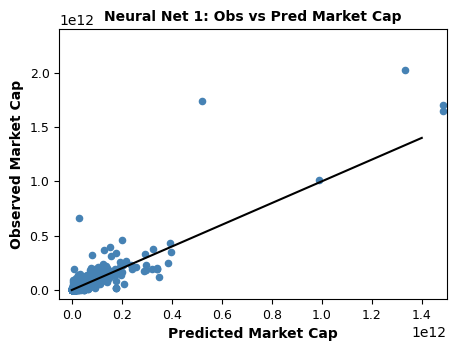

In [54]:
#obs vs pred scatterplot
axes051 = df_nn_model_pred051.plot(x='mc_pred',y='mc_obs',kind='scatter',color='steelblue',figsize=(5,3.5))

axes051.set_title('Neural Net 1: Obs vs Pred Market Cap', fontsize = 10.0, fontweight='bold')
axes051.set_xlabel('Predicted Market Cap', fontsize = 10.0, fontweight='bold')
axes051.tick_params(axis='x', labelsize=9)
axes051.set_ylabel('Observed Market Cap', fontsize = 10.0, fontweight='bold') 
axes051.tick_params(axis='y', labelsize=9)
axes051.set_xlim(-0.5*10**11,1.5*10**12)     
axes051.set_ylim(-0.8*10**11,2.4*10**12)     

#y=x line
plt.plot([0,1.4*10**12],[0,1.4*10**12],'-',color='k')

plt.show()

<b>4.2 NEURAL NETWORK MODEL 2</b>

In the second neural network model, I fit the model via cross validation across a more limited range of regularization parameters for the linear and nonlinear weights.  Here, I set the L1 regularization parameters to be larger for the linear weights thereby increasing the constraints on the linear effects and set the L1 regularization parameters to be smaller for the nonlinear weights thereby allowing the nonlinear effects to be more flexible in their fit to the data. 

The idea here is to build a model that somewhat favors the nonlinear effects in an attempt to encourage the identification of more nuanced nonlinear features. 

First, I define the base model using the custom build function.

In [55]:
#NN Model 2
x_train_nfeat011 = tsr_x_train011.shape[1]
nn_model02 = nn_linnlin_build(df_yx_test_stats011,x_train_nfeat011,1,0.0001)
nn_model02.summary()

Model: "nn_linnlin"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 23)]         0                                            
__________________________________________________________________________________________________
lin1 (Dense)                    (None, 1)            24          input[0][0]                      
__________________________________________________________________________________________________
in_lin1_concat (Concatenate)    (None, 24)           0           input[0][0]                      
                                                                 lin1[0][0]                       
__________________________________________________________________________________________________
nlin1 (Dense)                   (None, 30)           750         in_lin1_concat[0][0]    

In this section, I fit the second neural network model.  I evaluate a set of models by cross validation with a grid search over the two L1 hyperparameters using mean absolute error (MAE) as the scoring metric.

As above for the first neural network, I perform cross validation with a grid search over two L1 regularization hyperparameters, one for the linear weights and one for the nonlinear weights.  However, in this grid search, I restrict the L1 regularization parameter for the linear weights to be larger values relative to these same hyperparameters in the first neural network model in an effort to more preciseluy identify any nonlinear feature effects. For this hyperparameter space, I searched many iterations over the space to identify the best-fitting models.  The fuller grid search results are stored in a json file.

An example of a subset of the grid search in the neighborhood of the parameters selected for the best model is shown below.

In [56]:
#NN Model 2: cross validation grid, L1 regularization
#parameter grid

nn_gscv_grid052 = {'l1_reg_lin':[0.01,0.02,0.03,0.04,0.05,0.08,0.10
                                 ,0.12,0.15,0.18,0.20,0.25,0.30,0.35,0.40],
    'l1_reg_nlin':[0.0001]}

#permuations of parameter grid
keys052, values052 = zip(*nn_gscv_grid052.items())
lst_nn_gscv_grid052 = [dict(zip(keys052, v052)) for v052 in itool.product(*values052)]

lst_nn_gscv_grid052 = [
    {'l1_reg_lin': 0.01, 'l1_reg_nlin': 0.0001},
    {'l1_reg_lin': 0.02, 'l1_reg_nlin': 0.0001},
    {'l1_reg_lin': 0.03, 'l1_reg_nlin': 0.0001},
    {'l1_reg_lin': 0.04, 'l1_reg_nlin': 0.0001},
    {'l1_reg_lin': 0.05, 'l1_reg_nlin': 0.0001},
    {'l1_reg_lin': 0.08, 'l1_reg_nlin': 0.0001},
    {'l1_reg_lin': 0.10, 'l1_reg_nlin': 0.0001},
    {'l1_reg_lin': 0.12, 'l1_reg_nlin': 0.0001},
    {'l1_reg_lin': 0.15, 'l1_reg_nlin': 0.0001}]

lst_nn_gscv_grid052

[{'l1_reg_lin': 0.01, 'l1_reg_nlin': 0.0001},
 {'l1_reg_lin': 0.02, 'l1_reg_nlin': 0.0001},
 {'l1_reg_lin': 0.03, 'l1_reg_nlin': 0.0001},
 {'l1_reg_lin': 0.04, 'l1_reg_nlin': 0.0001},
 {'l1_reg_lin': 0.05, 'l1_reg_nlin': 0.0001},
 {'l1_reg_lin': 0.08, 'l1_reg_nlin': 0.0001},
 {'l1_reg_lin': 0.1, 'l1_reg_nlin': 0.0001},
 {'l1_reg_lin': 0.12, 'l1_reg_nlin': 0.0001},
 {'l1_reg_lin': 0.15, 'l1_reg_nlin': 0.0001}]

In [57]:
#NN Model 2 cross validation
#clock start
gscv_start052 = dttm.datetime.now()
print(gscv_start052)

#grid size
n_grid052 = len(lst_nn_gscv_grid052)
iter_lblfill052 = int(np.ceil(np.log10(n_grid052))) + 1

#n features
x_train_nfeat011 = tsr_x_train011.shape[1]
#train parameters
n_epoch052 = 50
vrb052 = 0
chkpt_flpthbase052 = 'saved_nn_models/nn_model02_20211113demo/'
erlstp_pat052 = 10
#results
#chkpt_flpth_prbest052 = 'saved_nn_models/nn_model02_20211107r01/nn_model01_001_0.0002_0.0002'
lst_nn_model01_cvres052 = []

iter052 = 0
for p_grd052 in lst_nn_gscv_grid052:
    #iteration
    iter052 = iter052 + 1
    
    #grid parameters
    l1_reg_lin052 = p_grd052['l1_reg_lin']
    l1_reg_nlin052 = p_grd052['l1_reg_nlin']
    
    chkpt_flpth052 = ( chkpt_flpthbase052 + 'nn_model02_' + str(iter052).zfill(iter_lblfill052) + '_' +
        str(l1_reg_lin052) + '_' + str(l1_reg_nlin052))

    #build
    nn_model02 = nn_linnlin_build(df_yx_test_stats011,x_train_nfeat011,l1_reg_lin052,l1_reg_nlin052)
    #use last best
        #nn_model02 = keras.models.load_model(chkpt_flpth_prbest052)
    #fit 1
    optmthd052 = keras.optimizers.Adam(learning_rate=0.03)
    nn_model02_cvres01 = nn_model_fit(tsr_x_train011,tsr_y_train011,nn_model02,optmthd052,n_epoch052,vrb052,
        chkpt_flpth052,erlstp_pat052)
    #fit 2
    optmthd052 = keras.optimizers.SGD(learning_rate=0.02)
    nn_model02 = keras.models.load_model(chkpt_flpth052)
    nn_model02_cvres02 = nn_model_fit(tsr_x_train011,tsr_y_train011,nn_model02,optmthd052,n_epoch052,vrb052,
        chkpt_flpth052,erlstp_pat052)
    #fit 3
    optmthd052 = keras.optimizers.SGD(learning_rate=0.001)
    nn_model02 = keras.models.load_model(chkpt_flpth052)
    nn_model02_cvres03 = nn_model_fit(tsr_x_train011,tsr_y_train011,nn_model02,optmthd052,n_epoch052,vrb052,
        chkpt_flpth052,erlstp_pat052)
    
    #epoch stats
    df_epochhist052 = pd.DataFrame()
    df_epochhist052 = pd.DataFrame(nn_model02_cvres03[0].history)
    mae_min1_mn052 = df_epochhist052.loc[:,'mean_absolute_error'].min()
    vmae_min1_mn052 = df_epochhist052.loc[:,'val_mean_absolute_error'].min()
    mae_mink_mn052 = df_epochhist052.nsmallest(10,'mean_absolute_error').loc[:,'mean_absolute_error'].mean()
    mae_mink_sd052 = df_epochhist052.nsmallest(10,'mean_absolute_error').loc[:,'mean_absolute_error'].std()
    mae_mink_lepch052 = df_epochhist052.nsmallest(10,'mean_absolute_error').index.max() + 1
    vmae_mink_mn052 = df_epochhist052.nsmallest(10,'val_mean_absolute_error').loc[:,'val_mean_absolute_error'].mean()
    vmae_mink_sd052 = df_epochhist052.nsmallest(10,'val_mean_absolute_error').loc[:,'val_mean_absolute_error'].std()
    vmae_mink_lepch052 = df_epochhist052.nsmallest(10,'val_mean_absolute_error').index.max() + 1   
    mink_lepch052 = np.max([mae_mink_lepch052,vmae_mink_lepch052])
        
    #save results
    lst_cvresn052 = [iter052,p_grd052,chkpt_flpth052,mink_lepch052,mae_min1_mn052,vmae_min1_mn052,
        mae_mink_mn052,mae_mink_sd052,vmae_mink_mn052,vmae_mink_sd052]
    if iter052 == 1:
        lst_nn_model02_cvres052 = [lst_cvresn052]
    else:
        lst_nn_model02_cvres052.append(lst_cvresn052)
    
    print(iter052,l1_reg_lin052,l1_reg_nlin052,mae_mink_mn052,vmae_mink_mn052,dttm.datetime.now())
    
#results dataframe
col_cvresn052 = ['iteration','param_grid','chkpt_path','epoch_minval','mae_min','vmae_min',
    'mae_mn','mae_sd','vmae_mn','vmae_sd']
df_nn_model02_cvres052 = pd.DataFrame()
df_nn_model02_cvres052 = pd.DataFrame(lst_nn_model02_cvres052,columns=col_cvresn052)

#clock end
gscv_end052 = dttm.datetime.now()
gscv_elapsed052 = gscv_end052 - gscv_start052
print(gscv_start052,gscv_end052,gscv_elapsed052)

2021-11-13 23:26:12.577952
INFO:tensorflow:Assets written to: saved_nn_models/nn_model02_20211109trn01/nn_model02_01_0.01_0.0001/assets
INFO:tensorflow:Assets written to: saved_nn_models/nn_model02_20211109trn01/nn_model02_01_0.01_0.0001/assets
INFO:tensorflow:Assets written to: saved_nn_models/nn_model02_20211109trn01/nn_model02_01_0.01_0.0001/assets
INFO:tensorflow:Assets written to: saved_nn_models/nn_model02_20211109trn01/nn_model02_01_0.01_0.0001/assets
INFO:tensorflow:Assets written to: saved_nn_models/nn_model02_20211109trn01/nn_model02_01_0.01_0.0001/assets
INFO:tensorflow:Assets written to: saved_nn_models/nn_model02_20211109trn01/nn_model02_01_0.01_0.0001/assets
INFO:tensorflow:Assets written to: saved_nn_models/nn_model02_20211109trn01/nn_model02_01_0.01_0.0001/assets
INFO:tensorflow:Assets written to: saved_nn_models/nn_model02_20211109trn01/nn_model02_01_0.01_0.0001/assets
INFO:tensorflow:Assets written to: saved_nn_models/nn_model02_20211109trn01/nn_model02_01_0.01_0.0001

INFO:tensorflow:Assets written to: saved_nn_models/nn_model02_20211109trn01/nn_model02_07_0.1_0.0001/assets
INFO:tensorflow:Assets written to: saved_nn_models/nn_model02_20211109trn01/nn_model02_07_0.1_0.0001/assets
INFO:tensorflow:Assets written to: saved_nn_models/nn_model02_20211109trn01/nn_model02_07_0.1_0.0001/assets
INFO:tensorflow:Assets written to: saved_nn_models/nn_model02_20211109trn01/nn_model02_07_0.1_0.0001/assets
INFO:tensorflow:Assets written to: saved_nn_models/nn_model02_20211109trn01/nn_model02_07_0.1_0.0001/assets
INFO:tensorflow:Assets written to: saved_nn_models/nn_model02_20211109trn01/nn_model02_07_0.1_0.0001/assets
INFO:tensorflow:Assets written to: saved_nn_models/nn_model02_20211109trn01/nn_model02_07_0.1_0.0001/assets
INFO:tensorflow:Assets written to: saved_nn_models/nn_model02_20211109trn01/nn_model02_07_0.1_0.0001/assets
INFO:tensorflow:Assets written to: saved_nn_models/nn_model02_20211109trn01/nn_model02_07_0.1_0.0001/assets
INFO:tensorflow:Assets writt

In [58]:
filnm052 = 'saved_nn_models/nn_model02_20211109trn01/nn_model02_cvres_20211109.json'

#save results to json
#df_nn_model02_cvres052.to_json(filnm052) 

#load results from json
with open(filnm052) as f052:
    nn_model_dict052 = json.load(f052)
        
df_nn_model02_cvres052_load = pd.DataFrame.from_dict(nn_model_dict052)

del f052, nn_model_dict052

Below are the results of the model selection for the top 10 models sorted by MAE (mean_test_score).  

In [59]:
#cross validation results
pd.set_option('display.max_colwidth',80)
df_nn_model02_cvres052.sort_values(by='vmae_mn').head(10)

,iteration,param_grid,chkpt_path,epoch_minval,mae_min,vmae_min,mae_mn,mae_sd,vmae_mn,vmae_sd
1,2,"{'l1_reg_lin': 0.02, 'l1_reg_nlin': 0.0001}",saved_nn_models/nn_model02_20211109trn01/nn_model02_02_0.02_0.0001,50,0.404940,0.277386,0.405106,0.000129,0.281824,0.001966
5,6,"{'l1_reg_lin': 0.08, 'l1_reg_nlin': 0.0001}",saved_nn_models/nn_model02_20211109trn01/nn_model02_06_0.08_0.0001,50,0.417472,0.282362,0.417964,0.000221,0.287671,0.002743
6,7,"{'l1_reg_lin': 0.1, 'l1_reg_nlin': 0.0001}",saved_nn_models/nn_model02_20211109trn01/nn_model02_07_0.1_0.0001,50,0.417116,0.290523,0.417653,0.000280,0.294516,0.002136
7,8,"{'l1_reg_lin': 0.12, 'l1_reg_nlin': 0.0001}",saved_nn_models/nn_model02_20211109trn01/nn_model02_08_0.12_0.0001,50,0.422286,0.291269,0.422611,0.000186,0.296516,0.003151
3,4,"{'l1_reg_lin': 0.04, 'l1_reg_nlin': 0.0001}",saved_nn_models/nn_model02_20211109trn01/nn_model02_04_0.04_0.0001,50,0.508301,0.303843,0.508532,0.000130,0.306857,0.001622
4,5,"{'l1_reg_lin': 0.05, 'l1_reg_nlin': 0.0001}",saved_nn_models/nn_model02_20211109trn01/nn_model02_05_0.05_0.0001,49,0.509795,0.301228,0.510184,0.000211,0.306931,0.002127
2,3,"{'l1_reg_lin': 0.03, 'l1_reg_nlin': 0.0001}",saved_nn_models/nn_model02_20211109trn01/nn_model02_03_0.03_0.0001,50,0.506359,0.303949,0.506538,0.000087,0.307333,0.001932
0,1,"{'l1_reg_lin': 0.01, 'l1_reg_nlin': 0.0001}",saved_nn_models/nn_model02_20211109trn01/nn_model02_01_0.01_0.0001,47,0.503465,0.307619,0.503556,0.000040,0.310577,0.001203
8,9,"{'l1_reg_lin': 0.15, 'l1_reg_nlin': 0.0001}",saved_nn_models/nn_model02_20211109trn01/nn_model02_09_0.15_0.0001,50,0.534688,0.312811,0.535676,0.000630,0.315321,0.001182


Based on the above cross validation results, I selected a model with the following hyperparameters for further analysis and testing,

L1 linear regularization = 0.03, L1 nonlinear regularization = 0.0001,

noting that many of the best models performed very similarly in cross validation.

I fit this model to the training data, generate predictions for the target variable using the test data, and evaluate the accuracy of the predictions.  Accuracy is assessed on the original, untransformed test data. 

In [60]:
#load model
chkpt_flpth_best052 = 'saved_nn_models/nn_model02_20211109trn01/nn_model02_003_0.03_0.0001'
nn_model02_best052 = keras.models.load_model(chkpt_flpth_best052)

Predictions for the target variable and associated accuracy metrics are calculated on the original, untransformed data.

In [61]:
#predictions
#transformed
df_nn_model_pred052 = pd.concat([df_y_test011,pd.Series(nn_model02_best052.predict(tsr_x_test011).ravel(),
    index=df_x_test011.index)],axis=1)
df_nn_model_pred052.columns = ['y_obs','y_pred']

#unscaled, inverse transform
df_nn_model_pred052 = pd.concat([df_nn_model_pred052,df_yx_test_core011.loc[:,'mktcap_sec_tp1']],axis=1)
df_nn_model_pred052.rename(columns={'mktcap_sec_tp1':'mc_obs'},inplace=True)

df_nn_model_pred_temp052 = pd.concat([df_x_test011.loc[:,['rev']],df_nn_model_pred052.loc[:,['y_pred']].copy()],axis=1)
df_nn_model_pred_temp052.columns = ['rev','mktcap_sec_tp1']

lst_nn_model_pred_invtr052 = inv_transform(df_nn_model_pred_temp052,df_yx_test_featmap011,k_test011,
    df_yx_test_posneg011,df_yx_test_stats011)
df_nn_model_pred_invtr052 = lst_nn_model_pred_invtr052[0]
df_nn_model_pred_invtr052.columns = ['rev','mc_pred']

df_nn_model_pred052 = pd.concat([df_nn_model_pred052,df_nn_model_pred_invtr052.loc[:,['mc_pred']]],axis=1)

#fit metrics
df_nn_model_pred052.loc[:,'mc_resid'] = df_nn_model_pred052.loc[:,'mc_obs'] - df_nn_model_pred052.loc[:,'mc_pred']
df_nn_model_pred052.loc[:,'mc_ae'] = df_nn_model_pred052.loc[:,'mc_resid'].abs()
df_nn_model_pred052.loc[:,'mc_ape'] = df_nn_model_pred052.loc[:,'mc_ae']/df_nn_model_pred052.loc[:,'mc_obs'].abs()
df_nn_model_pred052 = pd.concat([df_sec_yxdata_core011.loc[~is_train_core_seq011,lst_yx_coreatt011],
    df_nn_model_pred052],axis=1)

df_nn_model_pred052.head(10)

,ticker,mkt_cap_202109,fisc_seq,fisc_intvl,rpt_ccy,inscope_flg,fisc_date_t,fisc_date_tm1,fisc_date_tm4,fisc_date_tm5,meas_date_tp1,y_obs,y_pred,mc_obs,mc_pred,mc_resid,mc_ae,mc_ape
0,AAPL,2.358033e+12,5.0,91.0,USD,True,2021-03-31,2020-12-31,2020-03-31,2019-12-31,2021-06-28,11.436157,7.988582,2.245600e+12,1.578195e+12,6.674048e+11,6.674048e+11,0.297206
5,MSFT,2.172555e+12,5.0,91.0,USD,True,2021-03-31,2020-12-31,2020-03-31,2019-12-31,2021-06-28,13.407820,8.455223,2.020644e+12,1.152320e+12,8.683245e+11,8.683245e+11,0.429727
10,GOOGL,1.820299e+12,5.0,91.0,USD,True,2021-03-31,2020-12-31,2020-03-31,2019-12-31,2021-06-28,10.383738,10.006035,1.644663e+12,1.577290e+12,6.737334e+10,6.737334e+10,0.040965
15,GOOG,1.820298e+12,5.0,91.0,USD,True,2021-03-31,2020-12-31,2020-03-31,2019-12-31,2021-06-28,10.699974,10.006035,1.702156e+12,1.577290e+12,1.248660e+11,1.248660e+11,0.073358
20,AMZN,1.662777e+12,5.0,91.0,USD,True,2021-03-31,2020-12-31,2020-03-31,2019-12-31,2021-06-28,7.877630,4.383831,1.735721e+12,1.149074e+12,5.866462e+11,5.866462e+11,0.337984
25,FB,9.670962e+11,5.0,91.0,USD,True,2021-03-31,2020-12-31,2020-03-31,2019-12-31,2021-06-28,8.810701,8.518395,1.012507e+12,9.715907e+11,4.091639e+10,4.091639e+10,0.040411
30,TSLA,7.765921e+11,5.0,91.0,USD,True,2021-03-31,2020-12-31,2020-03-31,2019-12-31,2021-06-28,8.001895,0.878099,6.632374e+11,9.846152e+10,5.647758e+11,5.647758e+11,0.851544
35,BRK-B,6.240806e+11,5.0,91.0,USD,True,2021-03-31,2020-12-31,2020-03-31,2019-12-31,2021-06-28,5.790132,3.268994,1.004905e+12,6.810907e+11,3.238139e+11,3.238139e+11,0.322233
40,NVDA,5.168906e+11,5.0,91.0,USD,True,2021-05-02,2021-01-31,2020-04-26,2020-01-26,2021-07-30,2.221054,0.926479,1.210672e+11,6.603554e+10,5.503162e+10,5.503162e+10,0.454554
45,V,5.057191e+11,5.0,91.0,USD,True,2021-03-31,2020-12-31,2020-03-31,2019-12-31,2021-06-28,6.888777,3.139825,4.558462e+11,1.695093e+11,2.863369e+11,2.863369e+11,0.628144


As above for the other models, for the model predictions of the target variable I calculate r-squared and absolute percent error (APE) - both mean and median.  

The r-squared performance is substantially improved relative to the first neural network model, but the median-APE is very similar to both the linear regression model and the first neural network model, indicating no meaningful predictive improvement for this second, simple neural network model.

In [62]:
#r-squared, mean-ape, median-ape
nn2_r2 = r2_score(df_nn_model_pred052.loc[:,'mc_obs'], df_nn_model_pred052.loc[:,'mc_pred'])
nn2_meanape = df_nn_model_pred052.loc[:,'mc_ape'].mean()
nn2_medape = df_nn_model_pred052.loc[:,'mc_ape'].median()

df_model_testmet_smy011 = df_model_testmet_smy011.loc[df_model_testmet_smy011.index<=3,:]
#df_model_testmet_smy011 = pd.DataFrame([['NN-2',nn_r2,nn_meanape,nn_medape]],
    #    columns=['model','r-squared','mean-ape','median-ape'],index=[0])
df_model_testmet_smy011 = df_model_testmet_smy011.append(pd.Series(['NN-2',nn2_r2,nn2_meanape,nn2_medape],
    index=df_model_testmet_smy011.columns),ignore_index=True)

df_model_testmet_smy011

,model,r-squared,mean-ape,median-ape
0,LR,0.673865,1.758949,0.468692
1,XGB,0.891455,1.512398,0.398378
2,SVR,0.359517,1.504365,0.427169
3,NN-1,0.119180,2.369056,0.462433
4,NN-2,0.828051,1.932044,0.469456


Observed market capitalization is plotted against its prediction on the test data.  Values have been transformed back to their original scale.

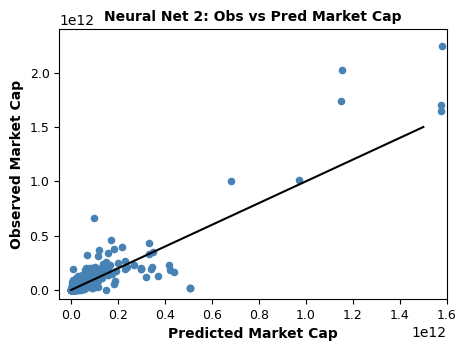

In [63]:
#obs vs pred scatterplot
axes052 = df_nn_model_pred052.plot(x='mc_pred',y='mc_obs',kind='scatter',color='steelblue',figsize=(5,3.5))

axes052.set_title('Neural Net 2: Obs vs Pred Market Cap', fontsize = 10.0, fontweight='bold')
axes052.set_xlabel('Predicted Market Cap', fontsize = 10.0, fontweight='bold')
axes052.tick_params(axis='x', labelsize=9)
axes052.set_ylabel('Observed Market Cap', fontsize = 10.0, fontweight='bold') 
axes052.tick_params(axis='y', labelsize=9)
axes052.set_xlim(-0.5*10**11,1.6*10**12)     #set_xlim(-0.1*10**11,0.1*10**12)
axes052.set_ylim(-0.8*10**11,2.4*10**12)     #set_ylim(-0.1*10**11,0.4*10**12)

#y=x line
plt.plot([0,1.5*10**12],[0,1.5*10**12],'-',color='k')

plt.show()

<b>4.3 FEATURE IMPORTANCE: NEURAL NETWORK MODELS</b>

As a final evaluation of the two neural network models, I calculate feature importance for just the linear weights to examine how the linear features in these models different in importance relative to each other and the other models considered above. It's important to note that this analysis ignores the nonlinear weights in these neural networks, so it is not a complete analysis in that regard.

In [64]:
#feature importance - neural network 1
#linear parameters
df_nn1_featimp051 = pd.concat([pd.DataFrame(df_x_train011.columns,columns=['feat_label']),
    pd.DataFrame(nn_model01_best051.layers[1].get_weights()[0],columns=['weight'])],axis=1)
df_xstd051 = pd.DataFrame(df_x_train011.std(),columns=['x_1std'])  #
df_xstd051.reset_index(inplace=True,drop=True)
df_nn1_featimp051 = pd.concat([df_nn1_featimp051,df_xstd051],axis=1)

df_nn1_featimp051.loc[:,'wght_1std'] = df_nn1_featimp051.loc[:,'weight']*df_nn1_featimp051.loc[:,'x_1std']
df_nn1_featimp051.loc[:,'importance_abs'] = df_nn1_featimp051.loc[:,'wght_1std'].abs()/df_nn1_featimp051.loc[:,'wght_1std'].abs().sum()
df_nn1_featimp051.loc[:,'importance'] = df_nn1_featimp051.loc[:,'wght_1std']/df_nn1_featimp051.loc[:,'wght_1std'].abs().sum()
df_nn1_featimp051.sort_values(by='importance_abs',ascending=False,inplace=True)
df_nn1_featimp051.reset_index(inplace=True)
df_nn1_featimp051.rename(columns={'index':'idx_feat'},inplace=True)
df_nn1_featimp051

,idx_feat,feat_label,weight,x_1std,wght_1std,importance_abs,importance
0,1,rev,-0.479776,1.000000,-0.479776,0.323583,-0.323583
1,17,div,0.395554,0.803696,0.317905,0.214410,0.214410
2,9,ni_ydy,-0.120412,1.000000,-0.120412,0.081211,-0.081211
3,5,gp,0.081299,0.999935,0.081294,0.054828,0.054828
4,18,div_ydy,-0.079584,0.999935,-0.079579,0.053672,-0.053672
5,0,clsadj_etf_t,0.072166,1.000000,0.072166,0.048672,0.048672
6,20,cf_op_ydy,-0.064006,1.000000,-0.064006,0.043169,-0.043169
7,10,ni_mgn,0.049664,1.000000,0.049664,0.033495,0.033495
8,6,gp_mgn,0.039504,0.999098,0.039469,0.026619,0.026619
9,15,sh_rprch,0.059914,0.561099,0.033618,0.022673,0.022673


In [65]:
#feature importance - neural network 2
#linear parameters
df_nn2_featimp052 = pd.concat([pd.DataFrame(df_x_train011.columns,columns=['feat_label']),
    pd.DataFrame(nn_model02_best052.layers[1].get_weights()[0],columns=['weight'])],axis=1)
df_xstd052 = pd.DataFrame(df_x_train011.std(),columns=['x_1std'])  #
df_xstd052.reset_index(inplace=True,drop=True)
df_nn2_featimp052 = pd.concat([df_nn2_featimp052,df_xstd052],axis=1)

df_nn2_featimp052.loc[:,'wght_1std'] = df_nn2_featimp052.loc[:,'weight']*df_nn2_featimp052.loc[:,'x_1std']
df_nn2_featimp052.loc[:,'importance_abs'] = df_nn2_featimp052.loc[:,'wght_1std'].abs()/df_nn2_featimp052.loc[:,'wght_1std'].abs().sum()
df_nn2_featimp052.loc[:,'importance'] = df_nn2_featimp052.loc[:,'wght_1std']/df_nn2_featimp052.loc[:,'wght_1std'].abs().sum()
df_nn2_featimp052.sort_values(by='importance_abs',ascending=False,inplace=True)
df_nn2_featimp052.reset_index(inplace=True)
df_nn2_featimp052.rename(columns={'index':'idx_feat'},inplace=True)
df_nn2_featimp052

,idx_feat,feat_label,weight,x_1std,wght_1std,importance_abs,importance
0,1,rev,-0.223537,1.000000,-0.223537,0.431150,-0.431150
1,17,div,0.162352,0.803696,0.130481,0.251667,0.251667
2,0,clsadj_etf_t,0.035659,1.000000,0.035659,0.068779,0.068779
3,5,gp,0.034429,0.999935,0.034427,0.066401,0.066401
4,9,ni_ydy,-0.018396,1.000000,-0.018396,0.035481,-0.035481
5,18,div_ydy,-0.018266,0.999935,-0.018265,0.035229,-0.035229
6,19,cf_op,0.011485,1.000000,0.011485,0.022152,0.022152
7,20,cf_op_ydy,-0.010402,1.000000,-0.010402,0.020064,-0.020064
8,8,ni,0.006402,1.000000,0.006402,0.012348,0.012348
9,4,gp_mgn_flg,-0.031485,0.201655,-0.006349,0.012246,-0.012246


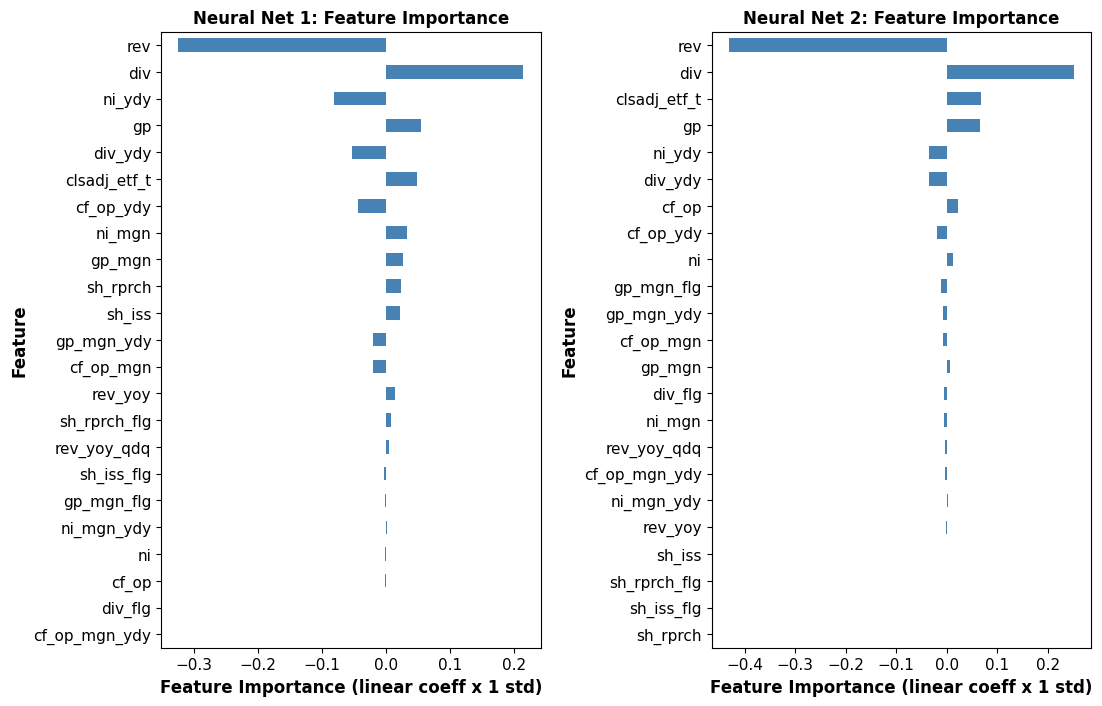

In [66]:
#plot horizontal bars
fig043, axes043 = plt.subplots(nrows=1,ncols=2,figsize=(12,8))
fig043.subplots_adjust(wspace=0.45)
axes_flt043 = axes043.flatten()

lst_df_feat043 = [df_nn1_featimp051.sort_values(by='importance_abs'),
                  df_nn2_featimp052.sort_values(by='importance_abs')]
lst_feat_title043 = ['Neural Net 1: Feature Importance','Neural Net 2: Feature Importance']
lst_feat_xlabel043 = ['Feature Importance (linear coeff x 1 std)','Feature Importance (linear coeff x 1 std)']

for ct043 in range(0,2):
    
    lst_df_feat043[ct043].plot.barh(ax=axes_flt043[ct043],x='feat_label',y='importance',rot=0,
            color='steelblue')

    axes_flt043[ct043].set_title(lst_feat_title043[ct043], fontsize = 12, fontweight='bold')
    axes_flt043[ct043].set_xlabel(lst_feat_xlabel043[ct043], fontsize = 12, fontweight='bold')
    axes_flt043[ct043].tick_params(axis='x', labelsize=11)
    axes_flt043[ct043].set_ylabel('Feature', fontsize = 12, fontweight='bold') 
    axes_flt043[ct043].tick_params(axis='y', labelsize=11)
    axes_flt043[ct043].get_legend().remove()
    

plt.show()

<b>NEURAL NETWORK MODELS: CONCLUSIONS</b>

This analysis suggests the following conclusions for the neural network models:

<ol type="1">
  <li>The neural network models did not improve accuracy of predictions and performed about as well as the linear regression model in terms of median-APE.</li>
  <li>Feature importance for linear weights is very similar between the two models with mostly minor differences in the relative magnitude of importance among features. Model 1 shows a bit more even importance across features and model 2 shows more concentration in the importance of the top features - this is consistent with model 2 placing more weight on nonlinear effects.  Interestingly, the top two features in the neural network models, revenue and dividend amount, are similar in importance when compared to the xgboost decision tree and support vector regression models which also rank these features as first and second, respectively, in relative importance.</li>
</ol> 

## 5 Conclusions

The key results of this notebook are:

<ol type="1">
  <li>Further featuring engineering relative to the preprocessing and training notebook impacted model accuracy on the test data relative to the results in the preprocessing and training notebook.  Median-APE is substantially improved for the linear regression and xgboost decision tree models, but median-APE is slightly worse for the support vector regression model.  The overall best model in terms of median-APE is the xgboost model with a value of 39.8%, which, interestingly, is only slightly better than the support vector regression model from the preprocessing and training notebook with a median-APE of 40.8%.  Nonetheless, these results suggest the importance of thoughtful exploratory data analysis and detailed feature engineering.</li> 
  <li>Two simple neural network models do not improve upon the predictive accuracy of the baseline models.  The neural networks models perform about as well as the linear regression model in terms of median-APE.</li> 
  <li>In terms of feature importance in the various models, there are both substantial similarities and meaningful differences among the different models. These comparisons warrant further investigation to better understand these models in terms of interpretability of the features, especially the nonlinear effects.</li> 
  <li>The core business use case is to understand and predict the valuation of publicly-traded companies as measured by market capitalization.  A core goal is to predict next fiscal period valuations given information from current and prior fiscal period financial metrics.  The models are not strongly predictive, with the best model, the xgboost decision tree, having a median absolute percent error of about 40%.  Interesting, the xgboost decision tree model, with median-APE of about 40%, is not a large improvement upon the linear regression model with a median-APE of about 47% despite that the former model is substantially more complex and capable of modeling very nonlinear feature effects.  This small difference between the best and worst models begs the question of how much predictive information exists in the features in this data set beyond what can be modeled in the xgboost decision tree.</li> 
   <li>Given the improvement in fit in the models after further feature engineering (relative to the preprocessing and training notebook), the differences in feature importance among competing models, and the small range in performance difference between the most and least predictive models, these results suggest a future course of action that is grounded in further exploratory data analysis and feature engineering. A better understanding of individual features and how they interect with each other can guide future data capture and model architecture and perhaps help identify both data and models that can offer better predictions.  One specific path is to explore segmentation and heterogeneity within the data and perhaps then leverage mixture-type models.  The data may be segmented by sector with, as an example, companies in the utilities sector following a different model than companies in other sectors such as finance and technology.  An important task will be how to identify such segments, either based on business knowledge or allowing model structure to identify underlying segments, or perhaps some blend of these approaches.</li>      